# Supernovae data analysis

24 Novembre 2022\
Tristan Hoellinger\
Exercise subject by Florent Leclercq

Objectives:
- estimate likelihoods of cosmological parameters based on fitting the theoritical relationship between apparent brightness and distance of standard candles
- play with Markov Chain Monte Carlo

## Set up the environment

### Set working directory

In [1]:
# wd = "/Users/hoellinger/kDrive/travail/recherche_these/leclercq/MCMC/"
wd = "/Users/hoellinger/Documents/MCMC_rendu/"

### Import libraries

In [2]:
%load_ext autoreload
%autoreload 2
from utilities import plot_contour_and_trajectory, plot_evolution_acceptance_rate, evolution_of_Rhats, plot_evolution_Rhats, plot_contours, estimate_mean_and_covariance_of_parameters, superimpose_posteriors_contours_on_true_likelihood, gen_Gaussian_prior, get_weights, plot_densities, plot_marginals, plot_contour_and_trajectory_3dL
from main import MH_sampler, compute_acceptance_rate, merge_lists, compute_Rhats, HMC_sampler, autocorr, compute_autocorr_time, MH_3d_sampler_gaussian 
import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax import grad
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Load and check data

In [3]:
jla_mub = pd.read_csv(wd + "data/jla_mub.txt", sep=' ', header=None, names=['z', "mu"])
Nbins = len(jla_mub)
jla_mub_comatrix_raw = pd.read_csv(wd + "data/jla_mub_covmatrix.txt", header=None)
print("OK") if Nbins==int(np.sqrt(len(jla_mub_comatrix_raw))) else print("sizes don't match")
jla_mub_comatrix = jla_mub_comatrix_raw.to_numpy().reshape((Nbins, Nbins))

OK


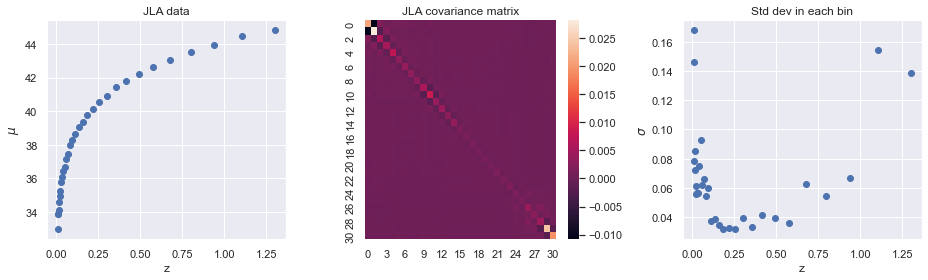

In [4]:
plt.figure(figsize=(13, 4))
plt.subplot(131)
plt.plot(jla_mub.z, jla_mub.mu, 'o')
plt.xlabel('z')
plt.ylabel(r"$\mu$")
plt.title("JLA data")
plt.subplot(132)
sns.heatmap(jla_mub_comatrix)
plt.title("JLA covariance matrix")
plt.subplot(133)
sigmas_bins = np.sqrt(np.diag(jla_mub_comatrix))
plt.plot(jla_mub.z, sigmas_bins, 'o')
plt.xlabel('z')
plt.ylabel(r"$\sigma$")
plt.title("Std dev in each bin")
plt.tight_layout()
plt.show()

We recall that each $z$-bin contains distances values averaged over multiple supernovae, hence the non-homogeneous / non-zero values on the diagonal.

### Default physical constants

See `main.py`.

## Preliminary analysis

### Theoritical distance modulus for a flat universe

Le module de distance (différence entre la magnitude apparente et la magnitude absolue) est donné par la relation
$$
\mu \overset{\Delta}{=} m-M = 25 - 5\log_{10}h + 5\log_{10} \left( \frac{D^*_{L}}{\mathrm{Mpc}} \right)
$$
avec $h=\dfrac{H_0}{100}$ le paramètre de Hubble adimensionné.

Dans le modèle standard, et pour un Univers plat ($\Omega_k$=0), la distance de luminosité (ajustée à $h=1$) est donnée par
$$
D^*_{L} = \frac{c}{100}\,(1+z) \int_0^z \frac{dz'}{\sqrt{1 - \Omega_{m} + \Omega_{m} (1+z')^3}}
$$

Pour $\Omega_m\in[0.2,1]$, on peut approximer cette intégrale (en commettant une erreur $<0.4\%$) par
$$
D^*_{L} = \frac{c}{100}\,(1+z) \left[ \eta\left(1,\Omega_m\right) - \eta\left(\dfrac{1}{1+z},\Omega_m\right) \right]
$$

avec, en notant $s^3 = \dfrac{1 - \Omega_m}{\Omega_m}$,
$$
\eta(a,\Omega_m) = 2\,\sqrt{s^3+1}\left(\dfrac{1}{a^4}-0.1540\dfrac{s}{a^3}+0.4304\dfrac{s^2}{a^2} + 0.19097\dfrac{s^3}{a}+0.066941\,s^4 \right)^{-1/8}
$$

Let us check our data against this formula, for a few values of $\Omega_m$.

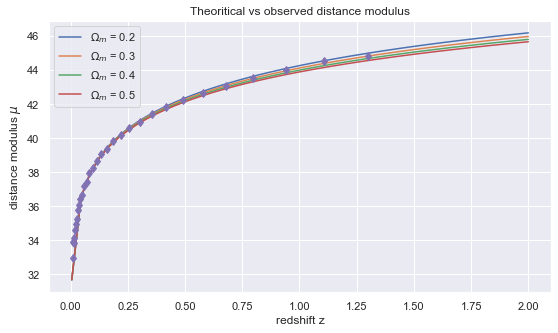

In [9]:
Omegams = [.2,.3,.4,.5]
zmin = min(jla_mub.z)/2. ; zmax = 2.
zz = np.linspace(zmin,zmax,50)
plt.figure(figsize=(9, 5))
for Omegam in Omegams:
    plt.plot(zz, mu(zz, Omegam), label=r"$\Omega_m$ = "+str(Omegam))
    plt.legend()
plt.plot(jla_mub.z, jla_mub.mu, 'd', label=r"obs. $\mu$")
plt.xlabel("redshift z")
plt.ylabel(r"distance modulus $\mu$")
plt.title("Theoritical vs observed distance modulus")
plt.show()

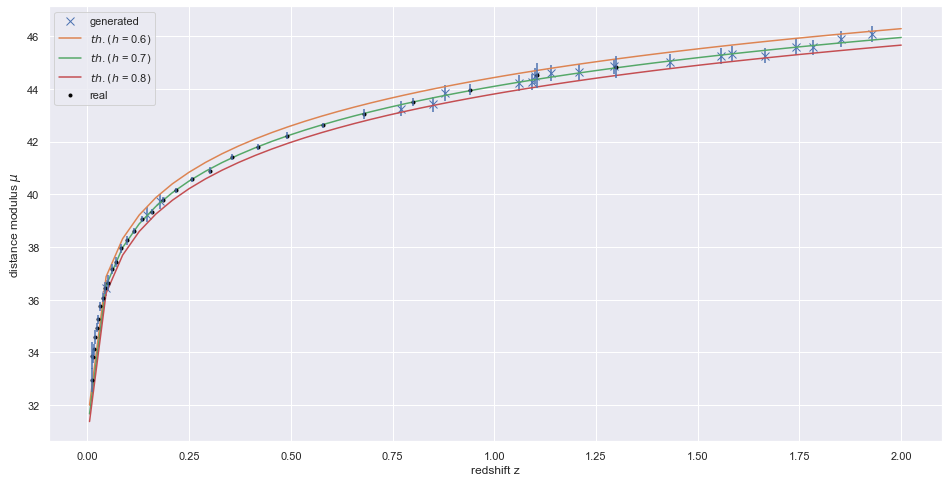

In [10]:
np.random.seed(0)
Nsamples = 20
z_samples = np.random.uniform(zmin, zmax, Nsamples) # samples from uniform distribution in [zmin, zmax)
mus_th = mu(z_samples, .3)
sig = 0.1
mus_gen = mus_th + np.random.normal(0, sig, Nsamples)
ids = np.argsort(z_samples)
sorted_z_samples = z_samples[ids]
sorted_mus_gen = mus_gen[ids]
plt.figure(figsize=(16,8))
plt.plot(sorted_z_samples, sorted_mus_gen, 'x', label=r"generated", markersize=8)
plt.errorbar(sorted_z_samples, sorted_mus_gen, yerr=3*sig, fmt='none')#, label="99% CI")
hh = [.6, .7, .8]
for h in hh:
    plt.plot(zz, mu(zz, .3, h), label=r"$th. (h$ = "+str(h)+')')
plt.plot(jla_mub.z, jla_mub.mu, '.', label=r"real", color='black')
plt.errorbar(jla_mub.z, jla_mub.mu, yerr=3*sigmas_bins, fmt='none')#, label="99% CI - assuming centered gaussian errors")
plt.xlabel("redshift z")
plt.ylabel(r"distance modulus $\mu$")
plt.legend()
plt.show()

## Principes généraux de MCMC

L'objectif visé dans ce type de problème est d'échantillonner une vraisemblance, ce qui est généralement coûteux *a fortiori* si la dimension de l'espace des paramètres $\Omega$ est élevée.

Les méthodes de Monte Carlo par chaînes de Markov consistent à construire une chaîne dont la distribution d'équilibre $\pi$ est la distribution qu'on souhaite approcher. L'avantage majeur de ces méthodes est qu'il n'est pas nécessaire de savoir échantilloner $\pi$ qu'à un facteur près, ce qui permet de ne pas avoir à intégrer. Les méthodes MCMC n'échappent cependant pas au fléau de la dimension, mais s'en sortent mieux que les méthodes classiques de Monte Carlo.

Concrètement, dans les méthodes MCMC, on cherche à générer une suite markovienne de d'états $x_i$ avec un noyau de transition $q(x_i|x_{i-1})$ de telle manière que l'état d'équilibre de la chaîne soit la distribution rechercher $\pi$ (il faut donc au moins que la châine soit irréductible, apériodique et récurrente positive, pour assurer que $q$ admet un vecteur propre à gauche associé à la valeur propre 1).

L'idée générale des méthoeds MCMC va donc consister à choisir préférentiellement des nouveaux états qui se rapprochent des maxima de densité de la distribution recherchée, tout en s'assurant que la chaîne reste irréductible et apériodique.

## Sample the likelihood using the Metropolis-Hastings algorithm

### Define the likelihood function

We consider the parametric likelihood as a function of the parameters $\Omega_m$ and $h$, thus defining a parameter space $\Omega$ of dimension 2. In our case, the likelihood function of the problem is quite straightforward to compute, especially since we only have few data and thanks to the flat universe approximation.

In [11]:
SIGMA_INV = np.linalg.inv(jla_mub_comatrix)

In [12]:
def logL(Omegam, h=CONST_h, c=CONST_c, fb=True):
    if Omegam < 0 or Omegam > 1:
        return -np.inf # we ensure that the sampler will not go out of bounds but this is probably not the best way to do it
    else:
        mus_th = mu(jla_mub.z, Omegam, h, c, fb)
        return -0.5 * np.dot(np.dot((jla_mub.mu-mus_th), SIGMA_INV), (jla_mub.mu-mus_th))

argmax: Om = 0.30303030303030304
argmax: h = 0.7010101010101011
argmax= [0.29310345 0.70344828]


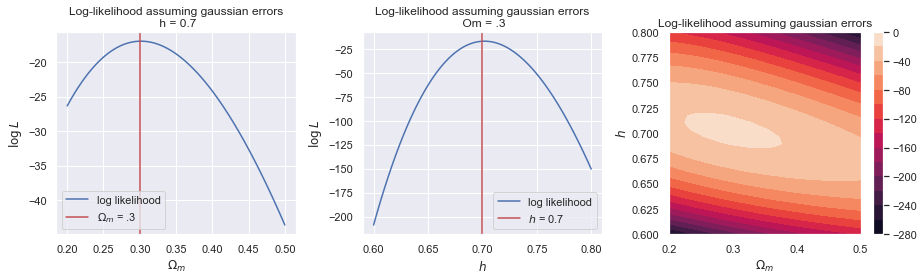

In [13]:
plt.figure(figsize=(13,4))
plt.subplot(1,3,1)
OO = np.linspace(.2, .5, 100)
likelihoods = [logL(O) for O in OO]
print("argmax: Om =", OO[np.argmax(likelihoods)])
plt.plot(OO, likelihoods, label=r"log likelihood")
plt.axvline(x=.3, color='r', label=r"$\Omega_m$ = .3")
plt.legend()
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$\log L$")
plt.title("Log-likelihood assuming gaussian errors\n h = 0.7")
plt.subplot(1,3,2)
hh = np.linspace(.6, .8, 100)
likelihoods = [logL(.3, h) for h in hh]
print("argmax: h =", hh[np.argmax(likelihoods)])
plt.plot(hh, likelihoods, label=r"log likelihood")
plt.axvline(x=CONST_h, color='r', label=r"$h$ = "+str(CONST_h))
plt.legend()
plt.xlabel(r"$h$")
plt.ylabel(r"$\log L$")
plt.title("Log-likelihood assuming gaussian errors\n Om = .3")
plt.subplot(1,3,3)
OO = np.linspace(.2, .5, 30)
hh = np.linspace(.6, .8, 30)
OO_hh = np.meshgrid(OO, hh)
OO_hh = np.array(OO_hh).reshape(2, -1).T
likelihoods = [logL(O, h) for O, h in OO_hh]
print("argmax=", OO_hh[np.argmax(likelihoods)])
plt.contourf(OO, hh, np.array(likelihoods).reshape(len(OO), len(hh)), 15)
plt.colorbar()
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$h$")
plt.title("Log-likelihood assuming gaussian errors")
plt.tight_layout()
plt.show()

### Implementation of the Metropolis-Hastings sampler

Intuitivement : à chaque itération, on tente de se déplacer dans l'espace des états. Si le candidat est un candidat plus probable, on l'accepte systématiquement, de sorte qu'on se rapproche des maxima de la vraisemblance et donc des zones d'intérêt de la distribution recherchée. Sinon, on accepte le candidat avec une probabilité qui décroit avec la différence de vraisemblance entre le candidat et l'état courant, de sorte qu'on continue toujours à explorer l'espace des états, ce qui assure l'irréductibilité de la chaîne.

Pourquoi la méthode permet de converger vers la distribution recherchée ? Intuitivement : imaginons qu'on se trouve plusieurs fois en un état fixé $x$, par exemple le maximum de la densité. Partant de là, le "taux de visite" des états voisins, avec l'algorithme de Metropolis-Hasting, sera directement proportionnel à la densité de probabilité de ces états. Ainsi, intuitivement, on va visiter les états un nombre de fois proportionnel à leur densité, et donc se rapprocher des maxima de la densité qu'on souhaite échantillonner.

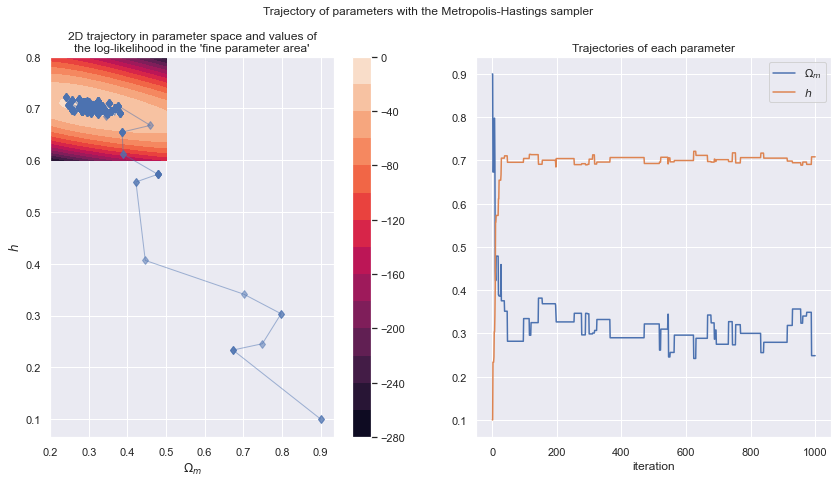

In [14]:
np.random.seed(0)

Omegam0 = 0.9
h0 = 0.1
Nsamples = 1000
sigma = .1
proposal = 'gaussian'

Omegas, hs = MH_sampler(Nsamples, Omegam0, h0, sigma, logL, proposal=proposal)
plot_contour_and_trajectory(logL, Omegas, hs)

$\sigma$ trop grand ! (voir suite)

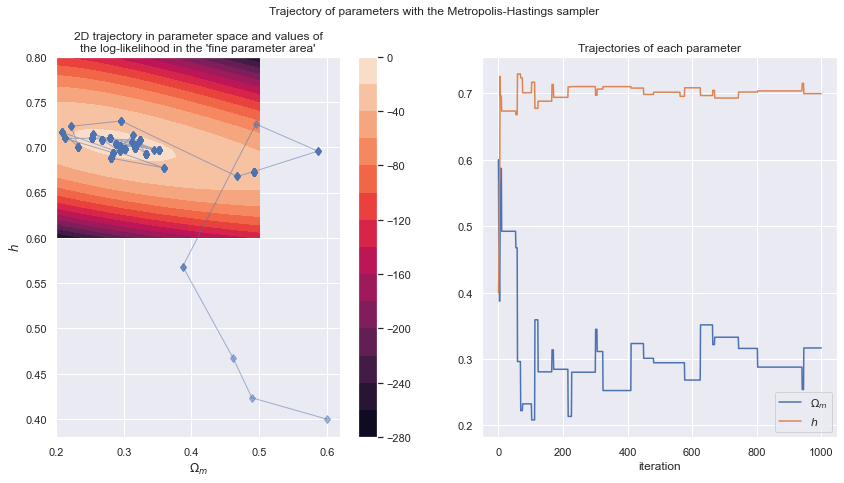

In [15]:
Omegam0 = 0.6
h0 = 0.4
Omegas, hs = MH_sampler(Nsamples, Omegam0, h0, sigma, logL, proposal=proposal)
plot_contour_and_trajectory(logL, Omegas, hs)

$\sigma$ trop grand ! (voir suite)

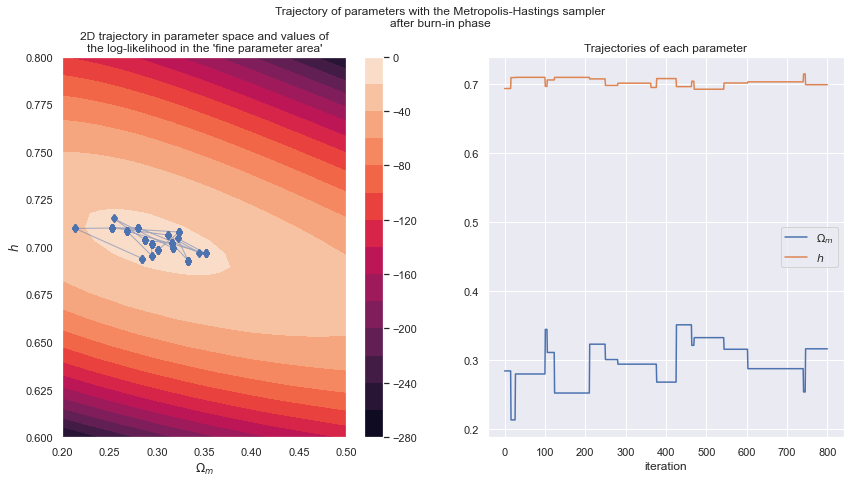

In [16]:
plot_contour_and_trajectory(logL, Omegas, hs, burn_length=200)

#### Impact de $\sigma$

In [17]:
print("Acceptance rate without burn-in: %.2f%%" % (100*compute_acceptance_rate(Omegas, hs)))
print("Acceptance rate with burn-in (eg after burning): %.2f%%" % (100*compute_acceptance_rate(Omegas, hs, start=200)))

Acceptance rate without burn-in: 3.20%
Acceptance rate with burn-in (eg after burning): 2.12%


We see on the plots that, with that set of parameters, the acceptance rate is very low - actually less than 5%, meaning that the algorithm, with this proposal distribution, is extremely conservative. This goes against our wish to explore the parameter space to accurately estimate the posterior distribution, so it might be better to decrease the proposal distribution variance. We explore this below. That being said, one should be careful not to decrease it too much, as this would lead to a very inefficient algorithm (because even if the acceptance rate would be high, the explored region of the parameter space would remain very tiny).

In [18]:
np.random.seed(0)
run=False # set to True to run the cell
if run:
    Nsamples = 1000
    for sig in [.001, .01, .02, .03, .05, .2]:
        print("#################\n## sigma=%.3f ##\n#################" % sig)
        Omegas_list = []
        hs_list = []
        proposal = 'gaussian'
        Omegas, hs = MH_sampler(Nsamples, Omegam0, h0, sig, logL, proposal=proposal)
        plot_contour_and_trajectory(logL, Omegas, hs, title=r"Trajectory of parameters with the Metropolis-Hastings sampler (proposal: %s, $\sigma=%.3f$)" % (proposal, sig))
        print("Acceptance rate: %.2f%%" % (100*compute_acceptance_rate(Omegas, hs)))
        print("Acceptance rate of last 500 samples: %.2f%%" % (100*compute_acceptance_rate(Omegas, hs, start=Nsamples-500)))
        Omegas_list.append(Omegas)
        hs_list.append(hs)
        proposal = 'top-hat'
        Omegas, hs = MH_sampler(Nsamples, Omegam0, h0, sig, logL, proposal=proposal)
        plot_contour_and_trajectory(logL, Omegas, hs, title=r"Trajectory of parameters with the Metropolis-Hastings sampler (proposal: %s, $\sigma=%.3f$)" % (proposal, sig))
        print("Acceptance rate: %.2f%%" % (100*compute_acceptance_rate(Omegas, hs)))
        print("Acceptance rate of last 500 samples: %.2f%%" % (100*compute_acceptance_rate(Omegas, hs, start=Nsamples-500)))
        Omegas_list.append(Omegas)
        hs_list.append(hs)
        plot_evolution_acceptance_rate(Omegas_list, hs_list, labels=['Gaussian proposal', 'Top-hat proposal'], title=r"for $\sigma=%.3f$" % sig)

On souhaite trouver un compromis entre exploration de l'espace des paramètres et convergence :
- si on augmente trop la variance de la loi de proposition (si la loi est trop diffuse), le taux de rejet sera très important et l'algorithme sera peu efficace et l'état se déplacera rarement dans l'espace des paramètres. C'est ce qu'on voit dans les exemples précédents, lorsque $\sigma\geq 0.2$.
- si on diminue trop la variance de la loi de proposition (si la loi est trop concentrée), le taux de rejet sera très faible, et l'algorithme sera également à la fois très lent (ci-dessus on voit toujours un drift après 1000 itérations pour $\sigma\leq 0.02$) et peu efficace : il ne visitera pas assez l'espace des paramètres car la chaîne restera confinée dans une petite réion de l'espace des paramètres.

Qualitativement, dans cette situation, les valeurs raisonnables de $\sigma$ semblent se situer autour de $0.02$. On choisit pour la suite $\sigma=0.02$.

#### Etude de la phase de "chauffe"

Pour déterminer le nombre d'itérations à effectuer avant de considérer qu'on s'est suffisamment rapproché de l'état stationnaire pour la suite de l'analyse, on s'assure au moins que la durée observée n'est pas propre à l'état de départ choisi, en considérant plusieurs chaines partant d'états initiaux différents.

## Starting from Omegam0=0.900, h0=0.100 ##
Acceptance rate: 27.97%
Acceptance rate of last 500 samples: 24.35%
## Starting from Omegam0=0.100, h0=0.900 ##
Acceptance rate: 30.77%
Acceptance rate of last 500 samples: 28.94%
## Starting from Omegam0=0.500, h0=0.500 ##
Acceptance rate: 29.17%
Acceptance rate of last 500 samples: 30.14%
## Starting from Omegam0=0.100, h0=0.100 ##
Acceptance rate: 29.57%
Acceptance rate of last 500 samples: 27.54%
## Starting from Omegam0=0.900, h0=0.900 ##
Acceptance rate: 30.27%
Acceptance rate of last 500 samples: 29.34%


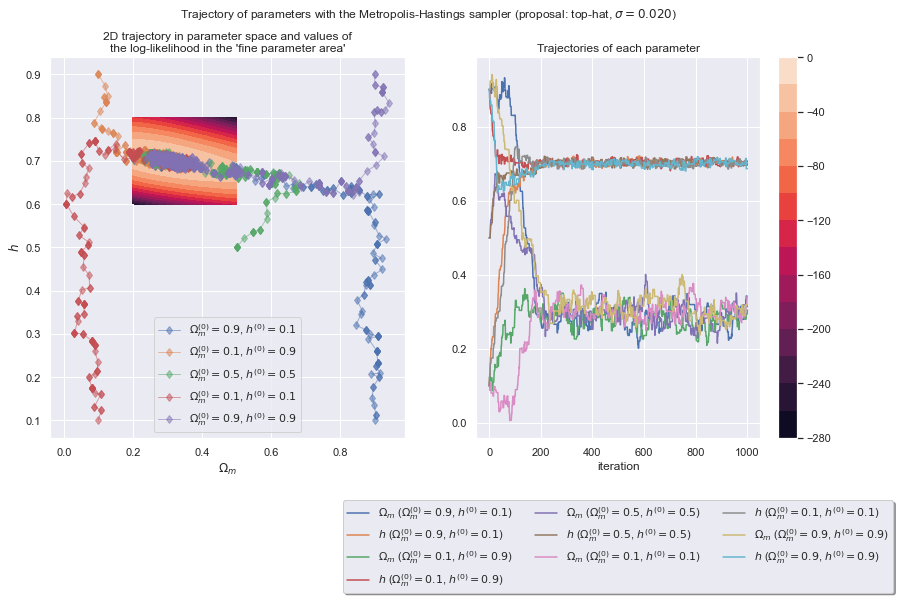

In [19]:
np.random.seed(0)
Nsamples = 1000 # 1000
sigma = .02
proposal = "top-hat"
force_bounds = False

Omegas_list_top_hat = []
hs_list_top_hat = []

plt.figure(figsize=(14, 7))
for Omegam0, h0 in [(0.9, 0.1), (0.1, 0.9), (0.5, 0.5), (0.1, 0.1), (0.9, 0.9)]:
    Omegas, hs = MH_sampler(Nsamples, Omegam0, h0, sigma, logL, proposal=proposal, force_bounds=force_bounds)
    Omegas_list_top_hat += [Omegas] # for future use
    hs_list_top_hat += [hs] # for future use
    plot_contour_and_trajectory(logL, Omegas, hs, overwrite=True, label=r"$\Omega_m^{(0)}=%.1f$, $h^{(0)}=%.1f$" % (Omegam0, h0), title=r"Trajectory of parameters with the Metropolis-Hastings sampler (proposal: %s, $\sigma=%.3f$)" % (proposal, sigma))
    print("## Starting from Omegam0=%.3f, h0=%.3f ##" % (Omegam0, h0))
    print("Acceptance rate: %.2f%%" % (100*compute_acceptance_rate(Omegas, hs)))
    print("Acceptance rate of last 500 samples: %.2f%%" % (100*compute_acceptance_rate(Omegas, hs, start=Nsamples-500)))
plt.colorbar(ax=plt.gca())
plt.show()

La phase de *burn-in*, qui est celle pendant laquelle il est la chaîne de Markov n'est pas encore suffisamment proche de sa distribution stationnaire, semble avoir une durée similaire quel que soit le point de départ. Concrètement, avec $\sigma=0.02$, il semble qu'on puisse considérer que la chaîne a atteint sa distribution stationnaire après ~250 itérations.

#### Statistique de Gelman-Rubin

Soient $m$ chaînes $\psi$ de longueur $n$. La variance totale des points peut se décomposer en deux termes :

- la variance inter-chaine, qui est la variance "entre les chaines"
$$
B = \dfrac{n}{m-1}\sum_{j=1}^m\left(\bar\psi_{\cdot j}-\bar{\psi}_{\cdot\cdot}\right)^2
$$
- la variance intra-chaine, qui est la variance "au sein des chaînes"
$$
W = \dfrac{1}{m}\sum_{i=1}^m \dfrac{1}{n-1}\sum_{j=1}^n \left(\psi_{ij} - \bar\psi_{\cdot j}\right)^2
$$

$W$ sous-estime la variance, et $\dfrac{n}{n-1}W + \dfrac{1}{n}B$ surestime la variance.

Dans le cas où une importance part de variabilité imputable à la différence entre les chaînes, cela traduit le fait que les chaînes sont encore éloignées de l'état stationnaire. Dans le cas où la variabilité est complèteùent expliquée par la variance intra-chaine, cela signie que les chaînes sont suffisamment proches de l'état stationnaire.

A un instant donné, le potentiel de réduction de variabilité (PSRF) est alors donné par :
$$
\hat R = \sqrt{\dfrac{n}{n-1} + \dfrac{1}{n}\dfrac{B}{W}}
$$

Rhat(Omega_m) = 1.0135
Rhat(h) = 1.0098
Convergence reached after 298 samples (threshold: Rhat < 1.1)
Convergence reached after 437 samples (threshold: Rhat < 1.05)
Convergence reached after -1 samples (threshold: Rhat < 1.01)


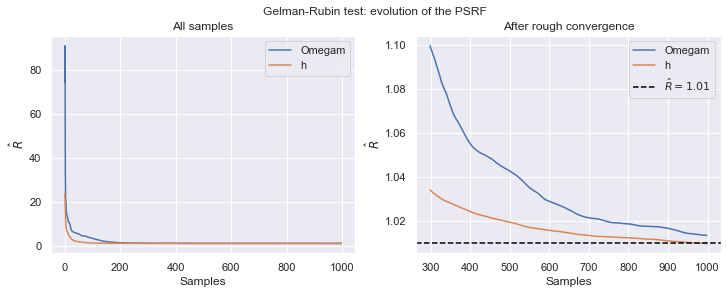

In [20]:
chain = merge_lists(Omegas_list_top_hat, hs_list_top_hat)
Rhats = compute_Rhats(chain, start=0, end=None)
print("Rhat(Omega_m) = %.4f\nRhat(h) = %.4f" % (Rhats[0], Rhats[1]))
RR = evolution_of_Rhats(chain)
plot_evolution_Rhats(RR, ["Omegam", "h"])

On va considérer que les chaînes (avec la proposal top-hat) ont atteint leur distribution stationnaire après 300 itérations.

## Starting from Omegam0=0.900, h0=0.100 ##
Acceptance rate: 29.04%
Acceptance rate of last 500 samples: 29.94%
## Starting from Omegam0=0.100, h0=0.900 ##
Acceptance rate: 30.73%
Acceptance rate of last 500 samples: 28.54%
## Starting from Omegam0=0.500, h0=0.500 ##
Acceptance rate: 31.98%
Acceptance rate of last 500 samples: 29.54%
## Starting from Omegam0=0.100, h0=0.100 ##
Acceptance rate: 30.13%
Acceptance rate of last 500 samples: 31.54%
## Starting from Omegam0=0.900, h0=0.900 ##
Acceptance rate: 30.23%
Acceptance rate of last 500 samples: 32.14%


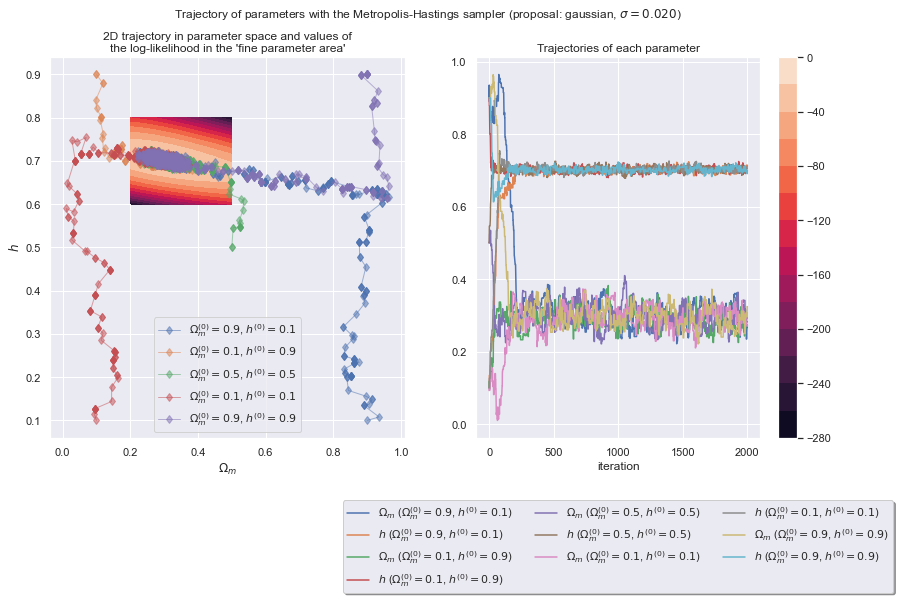

In [21]:
np.random.seed(0)
Nsamples = 2000 # 1000
sigma = .02
proposal = "gaussian"
force_bounds = False

Omegas_list_gaussian = []
hs_list_gaussian = []

plt.figure(figsize=(14, 7))
for Omegam0, h0 in [(0.9, 0.1), (0.1, 0.9), (0.5, 0.5), (0.1, 0.1), (0.9, 0.9)]:
    Omegas, hs = MH_sampler(Nsamples, Omegam0, h0, sigma, logL, proposal=proposal, force_bounds=force_bounds)
    Omegas_list_gaussian += [Omegas] # for future use
    hs_list_gaussian += [hs] # for future use
    plot_contour_and_trajectory(logL, Omegas, hs, overwrite=True, label=r"$\Omega_m^{(0)}=%.1f$, $h^{(0)}=%.1f$" % (Omegam0, h0), title=r"Trajectory of parameters with the Metropolis-Hastings sampler (proposal: %s, $\sigma=%.3f$)" % (proposal, sigma))
    print("## Starting from Omegam0=%.3f, h0=%.3f ##" % (Omegam0, h0))
    print("Acceptance rate: %.2f%%" % (100*compute_acceptance_rate(Omegas, hs)))
    print("Acceptance rate of last 500 samples: %.2f%%" % (100*compute_acceptance_rate(Omegas, hs, start=Nsamples-500)))
plt.colorbar(ax=plt.gca())
plt.show()

Rhat(Omega_m) = 1.0263
Rhat(h) = 1.0029
Convergence reached after 631 samples (threshold: Rhat < 1.1)
Convergence reached after 1094 samples (threshold: Rhat < 1.05)
Convergence reached after -1 samples (threshold: Rhat < 1.01)


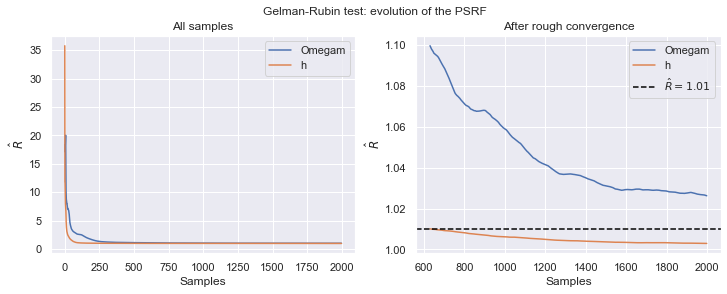

In [22]:
chain = merge_lists(Omegas_list_gaussian, hs_list_gaussian)
Rhats = compute_Rhats(chain, start=0, end=None)
print("Rhat(Omega_m) = %.4f\nRhat(h) = %.4f" % (Rhats[0], Rhats[1]))
RR = evolution_of_Rhats(chain)
plot_evolution_Rhats(RR, ["Omegam", "h"])

Avec la proposal gaussian, on va considérer que les chaines ont atteint leur distribution stationnaire après 700 itérations.

In [23]:
BURN_IN=700

### Likelyhood contours

Pour évaluer les contours de la vriasemblance, on utilisera la partie de la chaîne après la phase de "chauffe".

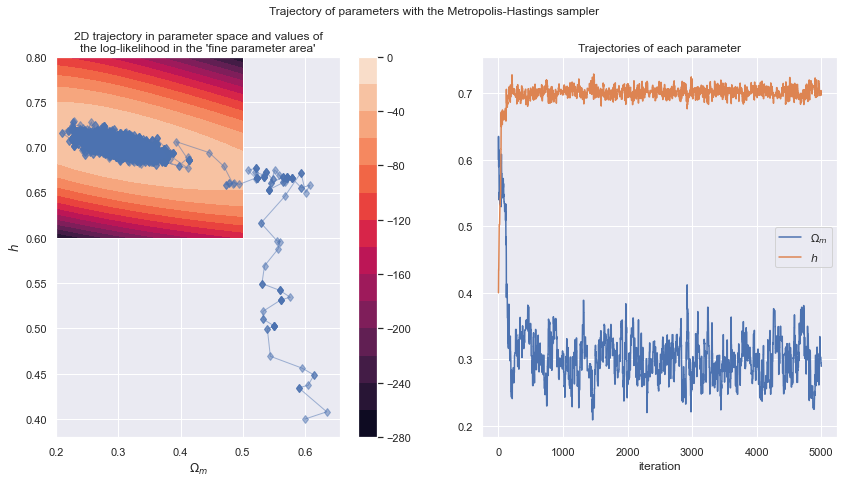

In [24]:
np.random.seed(0)
Omegam0 = 0.6
h0 = 0.4
Nsamples = 5000 # 1000
sigma = .02
proposal = 'gaussian'
force_bounds = False

Omegas, hs = MH_sampler(Nsamples, Omegam0, h0, sigma, logL, proposal=proposal)
plot_contour_and_trajectory(logL, Omegas, hs)
chain_sec5 = merge_lists([Omegas], [hs])[0]

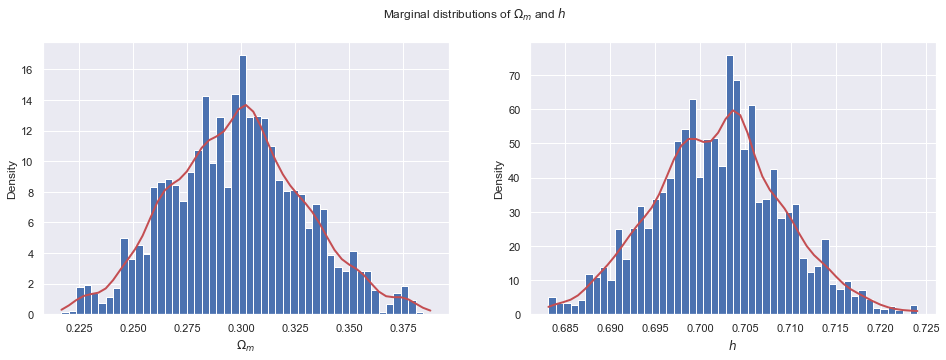

In [25]:
plot_marginals(chain_sec5, burn_in=BURN_IN, title=r"Marginal distributions of $\Omega_m$ and $h$")

Si on suppose que la distribution de la chaîne est gaussienne, les contours de la vraisemblance forment des ellipses. On considère en ce cas la distribution de la chaîne comme étant une gaussienne centrée en $(\hat\Omega_m,\hat h)$ et de matrice de variance-covariance $\hat\Sigma=\dfrac{1}{n-1}\sum_{i=1}^n(\psi_i-\hat\psi)(\psi_i-\hat\psi)^T$. Les demi-axes des ellipses de confiance sont données par les racines des valeurs propres de $\hat\Sigma$ (à multiplier par les valeurs de quantiles souhaitées pour une $\chi^2(2)$).

mean(h)= 0.702, mean(Omega_m) = 0.298


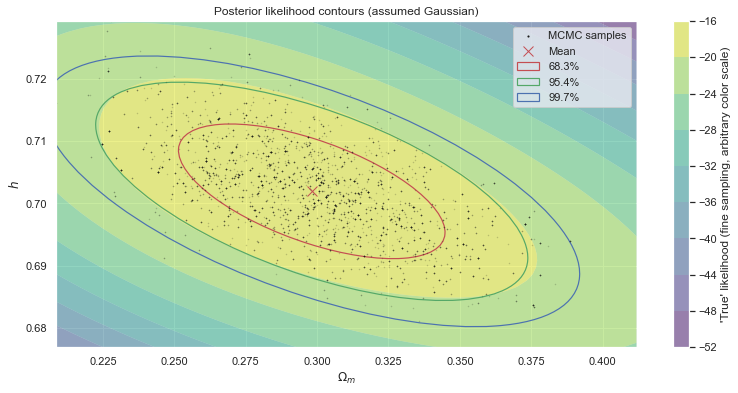

In [26]:
mean_sec5, covariance_sec5 = estimate_mean_and_covariance_of_parameters(chain_sec5, burn_in=BURN_IN)
print("mean(h)= %.3f, mean(Omega_m) = %.3f" % (mean_sec5[1], mean_sec5[0]))
superimpose_posteriors_contours_on_true_likelihood(logL, chain_sec5, burn_in=BURN_IN, title="Posterior likelihood contours (assumed Gaussian)")

On peut aussi utiliser une méthode d'estimation par noyaux de la densité a posteriori pour ensuite estimer la vraisemblance. La densité est estimée comme une somme de noyaux gaussiens centrés sur les points de la chaîne (éventuellement pondérés). 

$$
\hat f(\Omega_m,h) = \dfrac{1}{nh}\sum_{i=1}^n K\left(\dfrac{\Omega_m-\psi_{i1}}{h},\dfrac{h-\psi_{i2}}{h}\right)
$$
avec $K$ une fonction de noyau gaussien $K(x,y)=(1/2\pi)\exp\left(-\frac{x^2+y^2}{2}\right)$ et $n$ le nombre de points de la chaîne.

Partant de là, on utilise une méthode de rangs pour estimer les contours de crédibilité. Les contours obtenus dépendront fortement de la fenêtre $h$.

mean(h)= 0.702, mean(Omega_m) = 0.298


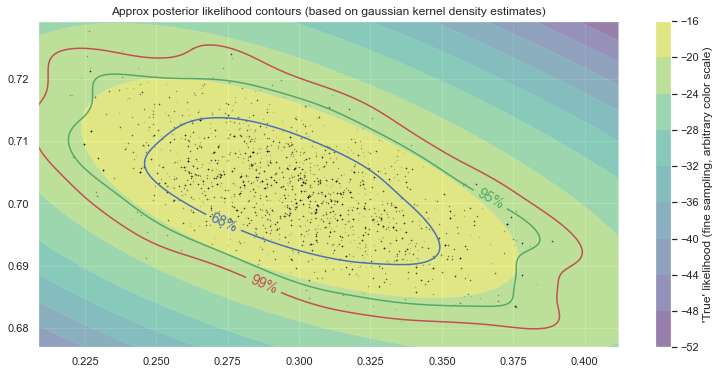

In [27]:
mean_sec5, covariance_sec5 = estimate_mean_and_covariance_of_parameters(chain_sec5, burn_in=BURN_IN)
print("mean(h)= %.3f, mean(Omega_m) = %.3f" % (mean_sec5[1], mean_sec5[0]))
superimpose_posteriors_contours_on_true_likelihood(logL, chain_sec5, burn_in=BURN_IN, bw=.4, assumed_Gaussian=False)

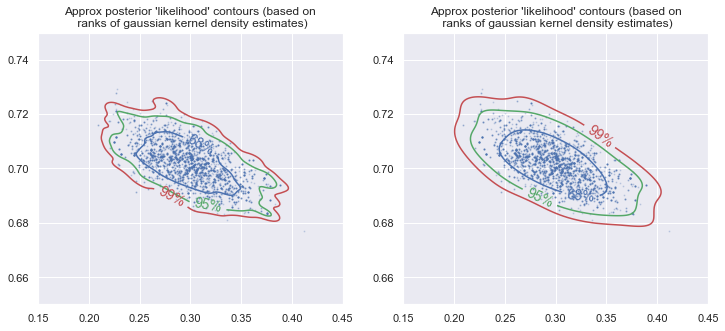

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_contours(chain_sec5, BURN_IN)
plt.subplot(122)
plot_contours(chain_sec5, BURN_IN, bw=0.5)
plt.show()

## Importance sampling

On peut mettre en oeuvre l'échantillonnage préférentielle de manière très simple, en pondérant les points de la chaîne de Markov par la densité de la loi de proposition. On obtient alors une chaîne de Markov pondérée, et on va pouvoir tenir compte de la pondération dans l'estimation des paramètres de la loi a posteriori, eg $\hat\Sigma=\dfrac{1}{n-1}\sum_{i=1}^n w_i(\psi_i-\tilde\psi)(\psi_i-\tilde\psi)^T$ avec $\tilde\psi$ la moyenne pondérée des points de la chaîne.


mean(h)= 0.705, mean(Omega_m) = 0.290


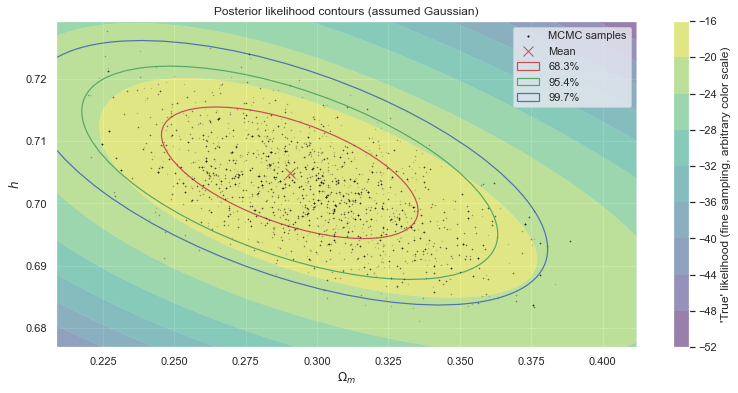

In [29]:
Gaussian_prior = gen_Gaussian_prior()

weights = get_weights(chain_sec5, Gaussian_prior, burn_in=BURN_IN)
mean, covariance = estimate_mean_and_covariance_of_parameters(chain_sec5, weights, burn_in=BURN_IN)
print("mean(h)= %.3f, mean(Omega_m) = %.3f" % (mean[1], mean[0]))
superimpose_posteriors_contours_on_true_likelihood(logL, chain_sec5, weights=weights, burn_in=BURN_IN, title="Posterior likelihood contours (assumed Gaussian - eventhough that's clearly not applicable)")

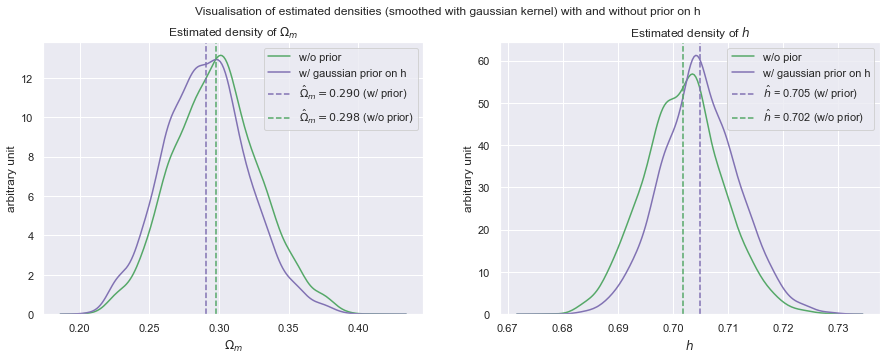

In [30]:
plot_densities(chain_sec5, BURN_IN, weights, mean, mean_sec5)

Ci-dessous on trace les contours de la vraisemblance estimée, en coloriant les points en fonction de la densité a priori.

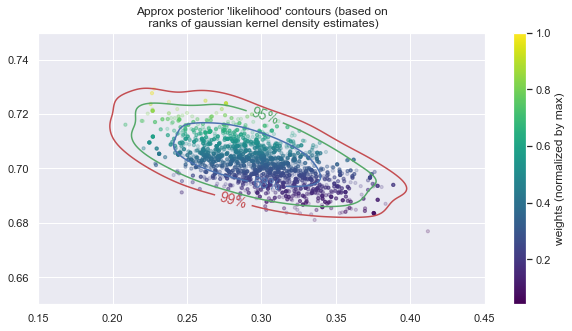

In [31]:
plt.figure(figsize=(10, 5))
plot_contours(chain_sec5, BURN_IN, bw=.5, weights=weights)

Let's also try with a completely wrong prior distribution, to see how the posterior distribution is affected.

mean(h)= 0.678, mean(Omega_m) = 0.404


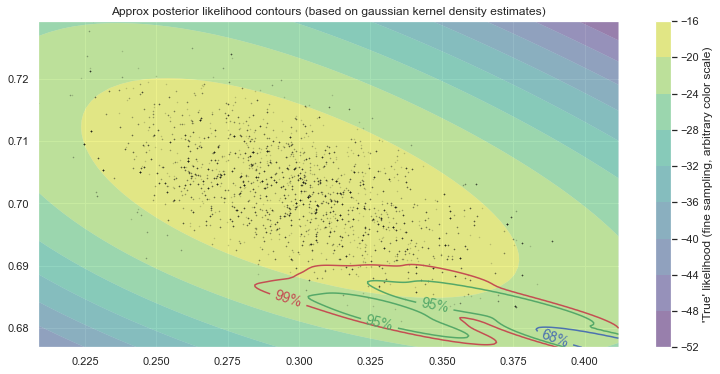

In [32]:
Gaussian_prior = gen_Gaussian_prior(mean=.2)

insane_weights = get_weights(chain_sec5, Gaussian_prior, burn_in=BURN_IN)
mean, covariance = estimate_mean_and_covariance_of_parameters(chain_sec5, insane_weights, burn_in=BURN_IN)
print("mean(h)= %.3f, mean(Omega_m) = %.3f" % (mean[1], mean[0]))
superimpose_posteriors_contours_on_true_likelihood(logL, chain_sec5, weights=insane_weights, burn_in=BURN_IN, assumed_Gaussian=False, bw=.3)

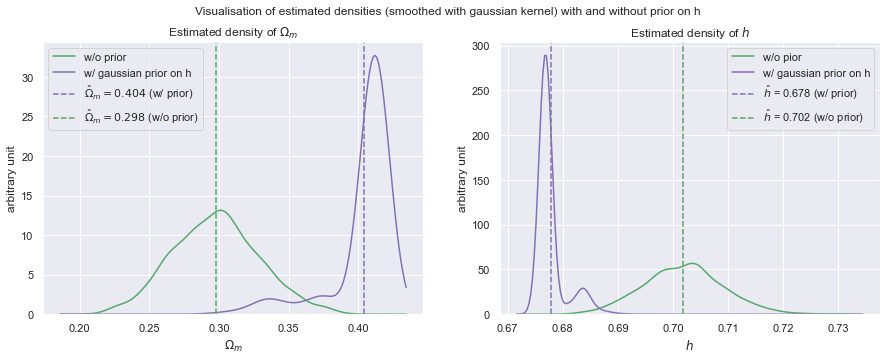

In [33]:
plot_densities(chain_sec5, BURN_IN, insane_weights, mean, mean_sec5)

## Hamiltonian Monte Carlo

### Préambule

Dans cette version de l'algorithme de Metropolis-Hastings, les déplacements proposés dans l'espace d'états sont issus d'un processus gouverné par une dynamique hamiltonienne, en introduisant une variable latente de moment conjugué. L'intérêt est de réduire la corrélation entre les états successifs, et ainsi de mieux explorer l'espace des paramètres et d'accélérer la convergence vers la distribution stationnaire. En effet, les états tirés à chaque itération pour la proposal sont propagés en utilisant une dynamique hamiltonienne, avec une méthode saute-mouton, et suivent ainsi essentiellement l'iso-énergie de l'état initial dans l'espace des phases.

Soit $H(q,p)=T(p)+U(q)$ l'Hamiltonien du système. Les équations de Hamilton sont :
$$
\begin{cases}
\dot{q} = \frac{\partial H}{\partial p} \\
\dot{p} = -\frac{\partial H}{\partial q}
\end{cases}
$$

$T$ est de la forme $T=p^TM^{-1}p/2$ où $M$ est une matrice symétrique positive définie, ie $T=\dfrac{1}{2}\|p\|^2_{M^{-1/2}}$ est la norme de $p$ dans la métrique induite par $M^{-1}$.

L'énergie potentielle $U$ est fonction de la loi a priori $\pi$, et de la vraisemblance : $U(q)=-\log(\pi(q))-\log(\mathcal{L}(q))$ (en sommant $\log(\mathcal{L}(q))$ sur les échantillons $q_i$ on obtiendrait un terme d'entropie de nos échantillons, qui serait maximal pour des échantillons distribués selon la vraisemblance). L'idée consiste à faire tendre le système vers l'équilibre thermodynamique, en provoquant les "interactions" entre les "particules" à l'aide de l'algorithme de Metropolis-Hastings.

On rappelle l'expression de la vraisemblance :
$$
\mathcal{L}(\Omega_m,h) = \exp\left(-\dfrac{1}{2}\sum_{i,j=1}^N [\mu_i - \mu_{\text{th}}(z_i\,;\,\Omega_m,h)]C_{ij}^{-1}[\mu_j - \mu_{\text{th}}(z_j\,;\,\Omega_m,h)]\right)
$$
eg
$$
-\log(\mathcal{L}) = \dfrac{1}{2}\sum_{i,j=1}^N [\mu_i - \mu_{\text{th}}(z_i\,;\,\Omega_m,h)]C_{ij}^{-1}[\mu_j - \mu_{\text{th}}(z_j\,;\,\Omega_m,h)]
$$
où $C_{ij}$ est la matrice de covariance des mesures, et
$$
\mu_{\text{th}}(z\,;\,\Omega_m,h) = 25 - 5\log_{10}h + 5\log_{10}D^{*}_L(z\,;\,\Omega_m)
$$

si bien que la dérivée de $U$ par rapport à $h$ est donnée par :
$$
\begin{align}
\frac{\partial U}{\partial h} &= \dfrac{1}{10\,h\log(10)}\sum_{i,j=1}^N\left(C_{ij}^{-1}\left[\mu_j - \mu_{\text{th}}(z_j\,;\,\Omega_m,h)\right] + \left[\mu_i - \mu_{\text{th}}(z_i\,;\,\Omega_m,h)\right]C_{ij}^{-1}\right)\\
&= \dfrac{1}{5\,h\log(10)}\sum_{i,j=1}^N\left(C_{ij}^{-1}\left[\mu_j - \mu_{\text{th}}(z_j\,;\,\Omega_m,h)\right]\right)\quad\text{(C symétrique)}\\
&= \dfrac{1}{5\,h\log(10)} C \left[\mu - \mu_{\text{th}}(z\,;\,\Omega_m,h)\right]
\end{align}
$$


La dérivée de $U$ par rapport à $\Omega_m$ est plus complexe à obtenir. On rappelle que $D^{*}_L(z\,;\,\Omega_m)$ est approximée par :

$$
D^*_{L} = \frac{c}{100}\,(1+z) \left[ \eta\left(1,\Omega_m\right) - \eta\left(\dfrac{1}{1+z},\Omega_m\right) \right]
$$

avec, en notant $s^3 = \dfrac{1 - \Omega_m}{\Omega_m}$,
$$
\eta(a,\Omega_m) = 2\,\sqrt{s^3+1}\left(\dfrac{1}{a^4}-0.1540\dfrac{s}{a^3}+0.4304\dfrac{s^2}{a^2} + 0.19097\dfrac{s^3}{a}+0.066941\,s^4 \right)^{-1/8}
$$

$s(\Omega_m)=\left(\dfrac{1-\Omega_m}{\Omega_m}\right)^{1/3} \implies \dfrac{\partial s}{\partial \Omega_m} = -\dfrac{1}{3}\left(\dfrac{1-\Omega_m}{\Omega_m}\right)^{-2/3} = -\dfrac{1}{3}\left(\dfrac{\Omega_m}{1-\Omega_m}\right)^{2/3} = \dfrac{1}{3}\left(\dfrac{1}{\Omega_m}-1\right)^{2/3}$

$$
\dfrac{\partial\left(2\sqrt{s^3+1}\right)}{\partial \Omega_m} = \dfrac{s^2\left(\dfrac{1}{\Omega_m}-1\right)^{2/3}}{\sqrt{s^3+1}}
$$

De là,
$$
\begin{align}
\frac{\partial\eta\left(a,\Omega_m\right)}{\partial\Omega_m} = &+\dfrac{s^2\left(\dfrac{1}{\Omega_m}-1\right)^{2/3}}{\sqrt{s^3+1}}\left(\dfrac{1}{a^4}-0.1540\dfrac{s}{a^3}+0.4304\dfrac{s^2}{a^2} + 0.19097\dfrac{s^3}{a}+0.066941\,s^4 \right)^{-1/8}\\
&- \dfrac{1}{4}\,\sqrt{s^3+1}\times \left(-0.1540\dfrac{1}{a^3}+0.8608\dfrac{s}{a^2} + 0.57291\dfrac{s^2}{a}+0.267882\,s^3 \right)\\
&\times \left(\dfrac{1}{a^4}-0.1540\dfrac{s}{a^3}+0.4304\dfrac{s^2}{a^2} + 0.19097\dfrac{s^3}{a}+0.066941\,s^4 \right)^{-9/8}
\end{align}
$$

Ce qui permet de calculer $\dfrac{\partial D^*_{L}}{\partial{\Omega_m}} = \dfrac{c}{100}\,(1+z) \left[ \partial_{\Omega_m}\eta\left(1,\Omega_m\right) - \partial_{\Omega_m}\eta\left(\dfrac{1}{1+z},\Omega_m\right) \right]$


Si l'expression analytique de notre approximation de la vraisemblance gagnait encore complexité, on gagnerait à utiliser une librairie de différentiation automatique. C'est en fait ce qu'on introduit déjà dans la suite. On évite les erreurs de calculs et on gagne en lisibilité dans l'implémentation.

### Différentiation automatique avec `Jax`


In [34]:
s_jax = lambda Om: ((1-Om)/Om)**(1/3)
def eta_jax(a,Omegam):
    s3 = (1-Omegam)/Omegam
    s = jnp.sign(s3)*jnp.power(jnp.abs(s3),1/3)
    return 2*jnp.sqrt(s3+1) * (1/a**4 - 0.1540*s/a**3 + 0.4304*s**2/a**2 + 0.19097*s3/a + 0.066941*s**4)**(-1/8)

DL_jax = lambda z, Om: CONST_c*(1+z)/100 * (eta_jax(1,Om) - eta_jax(1/(1+z),Om))
mu_jax = lambda z, Om, h: 25 - 5*jnp.log(h)/jnp.log(10) + 5*jnp.log(DL_jax(z,Om))/jnp.log(10)
data_mu = jnp.array(jla_mub.mu)
data_z = jnp.array(jla_mub.z)
data_sigma_inv = jnp.array(np.linalg.inv(jla_mub_comatrix))
def log_likelihood(Om, h):
    mu_matrix = mu_jax(data_z, Om, h)
    return -0.5 * jnp.dot((data_mu - mu_matrix).T, jnp.dot(data_sigma_inv, (data_mu - mu_matrix)))

In [35]:
def kinetic(p,M):
    return 0.5 * jnp.dot(p.T, jnp.dot(jnp.linalg.inv(M), p))

def std_Gaussian_prior(Om, h):
    return jnp.exp(-0.5 * (Om**2 + h**2))

def potential(Om, h, prior=None):
    if prior=="gaussian":
        return -log_likelihood(Om, h) - jnp.log(std_Gaussian_prior(Om, h))
    else:
        return -log_likelihood(Om, h)

def Hamiltonian(Om, h, p_vec, M, prior=None):
    return kinetic(p_vec,M) + potential(Om, h)

dUdOm = grad(potential, argnums=0)
dUdh = grad(potential, argnums=1)

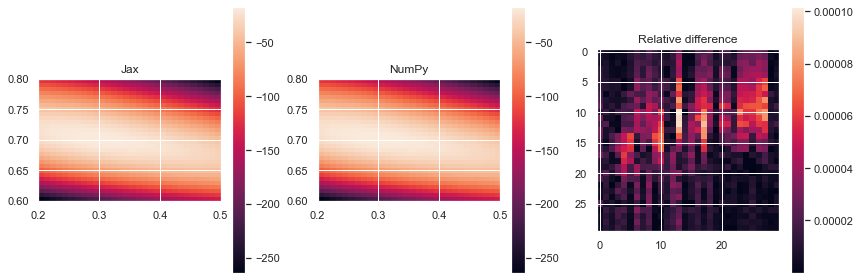

In [38]:
# evaluate the likelihood on a grid of values and plot it
# this is just to check visually on a small example that the analytic expression is correct (assuming the one from previous section is!)
Omvals = np.linspace(.2, .5, 30)
hvals = np.linspace(.6, .8, 30)
Om_grid, h_grid = np.meshgrid(Omvals, hvals)
logL_grid = np.zeros_like(Om_grid)
old_logL_grid = np.zeros_like(Om_grid)
for i in range(len(Omvals)):
    for j in range(len(hvals)):
        old_logL_grid[i,j] = logL(Om_grid[i,j], h_grid[i,j])
        logL_grid[i,j] = log_likelihood(Om_grid[i,j], h_grid[i,j])

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(logL_grid, extent=[.2, .5, .6, .8], origin='lower')
plt.colorbar()
plt.title("Jax")
plt.subplot(132)
plt.imshow(old_logL_grid, extent=[.2, .5, .6, .8], origin='lower')
plt.colorbar()
plt.title("NumPy")
plt.subplot(133)
diff = np.array(logL_grid - old_logL_grid)
diff = np.abs(diff) /np.maximum((np.abs(old_logL_grid)),1e-15)
plt.imshow(diff)
plt.colorbar()
plt.title("Relative difference")
plt.tight_layout()
plt.show()

Let us plot the partial derivative.

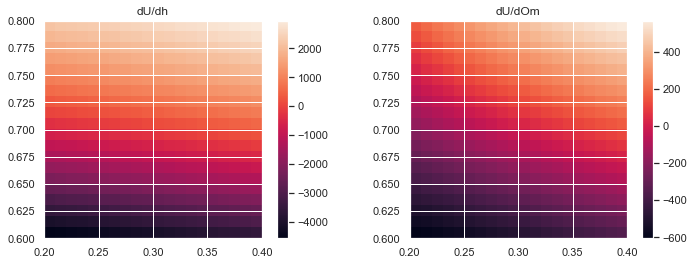

In [37]:
Omvals = jnp.linspace(.2, .4, 20)
hvals = jnp.linspace(.6, .8, 20)
Om_grid, h_grid = jnp.meshgrid(Omvals, hvals)
dUdh_grid = jnp.zeros_like(Om_grid)
dUdOm_grid = jnp.zeros_like(Om_grid)
for i in range(len(Omvals)):
    # print(i)
    for j in range(len(hvals)):
        dUdh_grid = dUdh_grid.at[i,j].set(dUdh(Om_grid[i,j], h_grid[i,j]))
        dUdOm_grid = dUdOm_grid.at[i,j].set(dUdOm(Om_grid[i,j], h_grid[i,j]))

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(dUdh_grid, extent=[.2, .4, .6, .8], origin='lower')
plt.colorbar()
plt.title("dU/dh")
plt.subplot(122)
plt.imshow(dUdOm_grid, extent=[.2, .4, .6, .8], origin='lower')
plt.title("dU/dOm")
plt.colorbar()
plt.show()

### HMC Sampler

We can finaly use the Hamiltonian Monte Carlo sampler (see its definition in `main.py` - its implementation is actually quite easy).

## Iteration:  99  ##
Acceptance rate without burn-in: 99.01%
Acceptance rate with burn-in (eg after burning): -0.00%


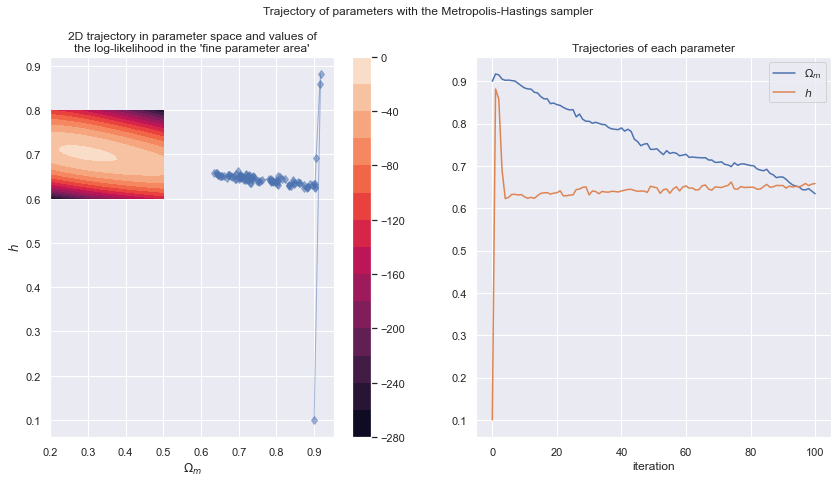

In [47]:
from main import HMC_sampler
np.random.seed(0)
Omegas, hs = HMC_sampler(dUdh, dUdOm, .9, .1, H=Hamiltonian, nsteps=10, timestep=.01, niter=100, randomized_N=True)

print("Acceptance rate without burn-in: %.2f%%" % (100*compute_acceptance_rate(Omegas, hs)))

plot_contour_and_trajectory(logL, Omegas, hs)

Acceptance rate too high with the default parameters.

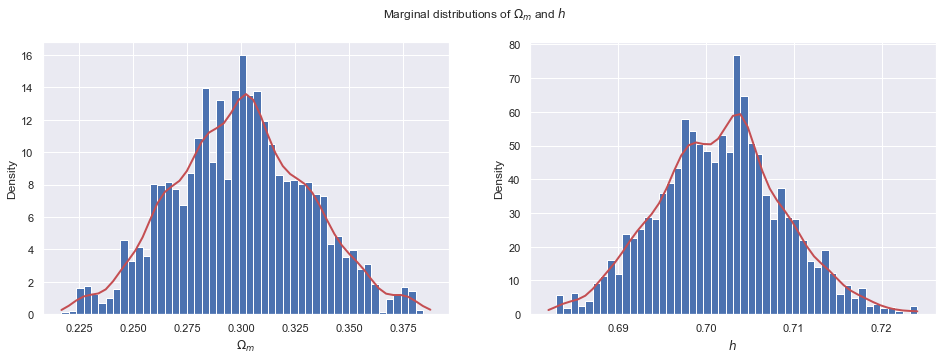

In [39]:
chain_sec7 = np.array([Omegas, hs]).T
plot_marginals(chain_sec7, burn_in=300, title=r"Marginal distributions of $\Omega_m$ and $h$")

## Iteration:  499  ##
## Starting from Omegam0=0.900, h0=0.900 ##
Acceptance rate: 99.80%


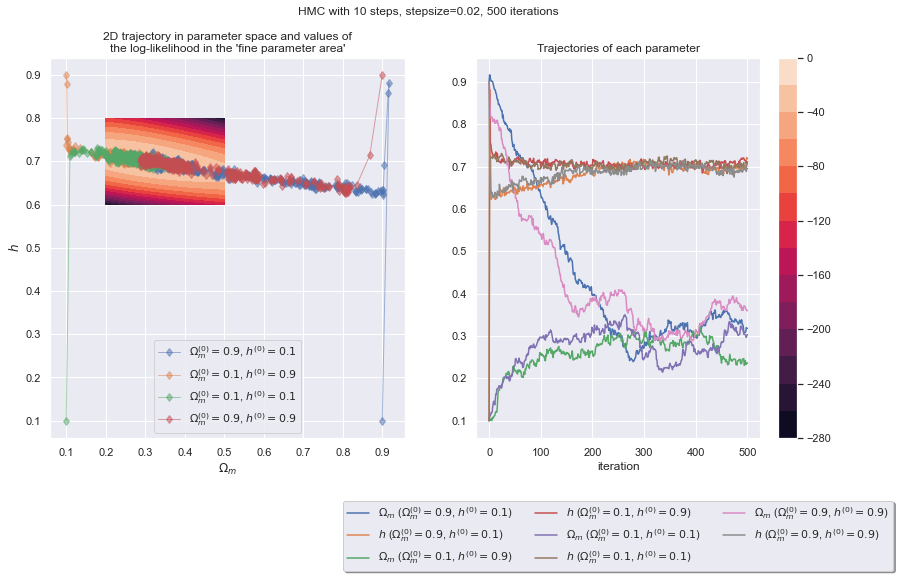

In [53]:
# warning: this takes several minutes to run
run = False
if run:
    np.random.seed(0)
    Nsamples = 500
    nstep = 10
    timestep = .01

    Omegas_list_sec7 = []
    hs_list_sec7 = []

    plt.figure(figsize=(14, 7))
    for Omegam0, h0 in [(0.9, 0.1), (0.1, 0.9), (0.1, 0.1), (0.9, 0.9)]:
        Omegas, hs = HMC_sampler(dUdh, dUdOm, Omegam0, h0, H=Hamiltonian, nsteps=nstep, timestep=timestep, niter=Nsamples, randomized_N=True)
        Omegas_list_sec7 += [Omegas] # for future use
        hs_list_sec7 += [hs] # for future use
        plot_contour_and_trajectory(logL, Omegas, hs, overwrite=True, label=r"$\Omega_m^{(0)}=%.1f$, $h^{(0)}=%.1f$" % (Omegam0, h0), title="HMC with %d steps, timestep=%.2f, %d iterations" % (nstep, timestep, Nsamples))
        print("## Starting from Omegam0=%.3f, h0=%.3f ##" % (Omegam0, h0))
        print("Acceptance rate: %.2f%%" % (100*compute_acceptance_rate(Omegas, hs)))
        # print("Acceptance rate of last 500 samples: %.2f%%" % (100*compute_acceptance_rate(Omegas, hs, start=Nsamples-500)))
    plt.colorbar(ax=plt.gca())
    plt.show()

Import the image of the result so that there is no need to re-run the above cells:

![](imageS/multiple_chain_HMC.png)

And `save chain_sec7` to file / or load it from file.

In [54]:
# chain_sec7 = merge_lists(Omegas_list_sec7, hs_list_sec7)
# np.save('results/chain_sec7.npy', chain_sec7)

chain_sec7 = np.load('results/chain_sec7.npy')

Rhat(Omega_m) = 1.0974
Rhat(h) = 1.0382
Convergence reached after 488 samples (threshold: Rhat < 1.1)
Convergence reached after -1 samples (threshold: Rhat < 1.05)
Convergence reached after -1 samples (threshold: Rhat < 1.01)


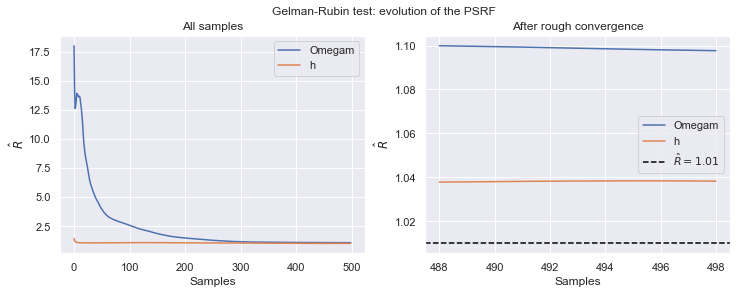

In [59]:
Rhats = compute_Rhats(chain_sec7, start=0, end=None)
print("Rhat(Omega_m) = %.4f\nRhat(h) = %.4f" % (Rhats[0], Rhats[1]))
RR = evolution_of_Rhats(chain_sec7)
plot_evolution_Rhats(RR, ["Omegam", "h"])

The variance of the momentum seem quite quite unbalanced wrt the shape of the true likelihood. We might reach a better convergence by using a matrix $M$ different from identity (je n'ai pas eu le temps d'investiguer cela plus en détails).

## Iteration:  999  ##
Acceptance rate without burn-in: 53.45%
Acceptance rate with burn-in (ie after burning): 53.50%


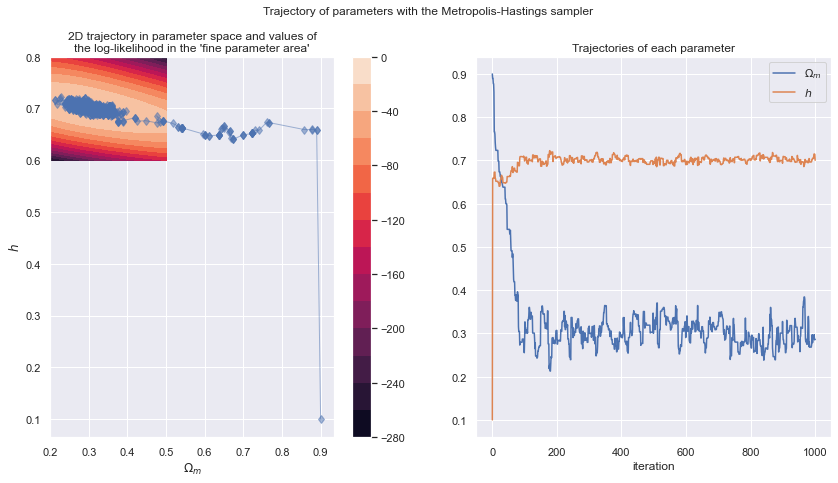

In [99]:
M = jnp.array([[100. , 0.], [0., 10.]])
Omegas, hs = HMC_sampler(dUdh, dUdOm, .9, .1, H=Hamiltonian, nsteps=5, timestep=.005, niter=1000, randomized_N=True, M=M)

print("Acceptance rate without burn-in: %.2f%%" % (100*compute_acceptance_rate(Omegas, hs)))
print("Acceptance rate with burn-in (ie after burning): %.2f%%" % (100*compute_acceptance_rate(Omegas, hs, start=300)))

plot_contour_and_trajectory(logL, Omegas, hs)

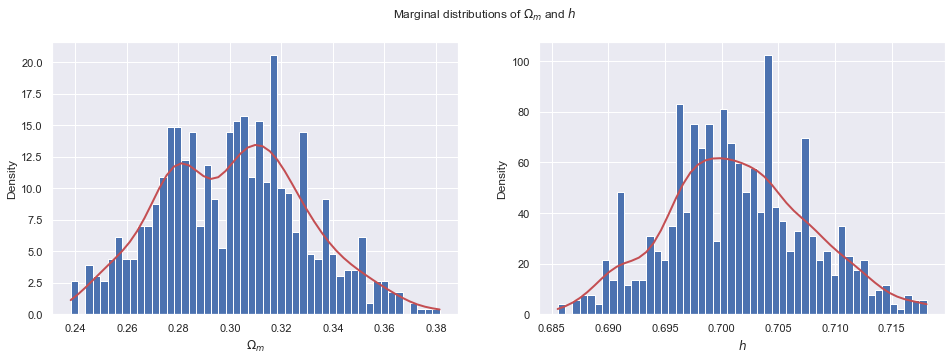

In [100]:
chain_tmp = np.array([Omegas, hs]).T
plot_marginals(chain_tmp, burn_in=200, title=r"Marginal distributions of $\Omega_m$ and $h$")

In [101]:
# warning: this takes several minutes to run
run = False
if run:
    np.random.seed(0)
    Nsamples = 500
    nstep = 10
    timestep = .01

    Omegas_list_sec7 = []
    hs_list_sec7 = []

    plt.figure(figsize=(14, 7))
    for Omegam0, h0 in [(0.9, 0.1), (0.1, 0.9), (0.1, 0.1), (0.9, 0.9)]:
        Omegas, hs = HMC_sampler(dUdh, dUdOm, Omegam0, h0, H=Hamiltonian, nsteps=nstep, timestep=timestep, niter=Nsamples, randomized_N=True, M=M)
        Omegas_list_sec7 += [Omegas] # for future use
        hs_list_sec7 += [hs] # for future use
        plot_contour_and_trajectory(logL, Omegas, hs, overwrite=True, label=r"$\Omega_m^{(0)}=%.1f$, $h^{(0)}=%.1f$" % (Omegam0, h0), title="HMC with %d steps, timestep=%.2f, %d iterations" % (nstep, timestep, Nsamples))
        print("## Starting from Omegam0=%.3f, h0=%.3f ##" % (Omegam0, h0))
        print("Acceptance rate: %.2f%%" % (100*compute_acceptance_rate(Omegas, hs)))
        # print("Acceptance rate of last 500 samples: %.2f%%" % (100*compute_acceptance_rate(Omegas, hs, start=Nsamples-500)))
    plt.colorbar(ax=plt.gca())
    plt.show()

### Approximation de l'Hamiltonien à partir de la densité approchée par Metroplis-Hastings

En utilisant la densité de probabilité approchée par Metroplis-Hastings, on avait obtenu à la section 5 une approximation de la moyenne et de la matrice de covariance de la vraisemblance. Si on suppose que la densité visée est gaussienne, on peut alors obtenir une approximation linéaire simple de l'énergie potentielle $U$.

On avait ainsi obtenu les contours suivants à la section 5 :

mean(h)= 0.702, mean(Omega_m) = 0.297


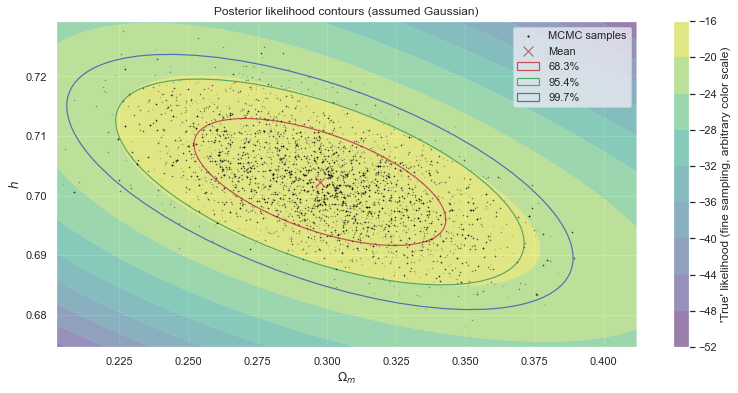

In [163]:
# mean_sec5, covariance_sec5 = estimate_mean_and_covariance_of_parameters(chain_sec5, burn_in=BURN_IN)
print("mean(h)= %.3f, mean(Omega_m) = %.3f" % (mean_sec5[1], mean_sec5[0]))
superimpose_posteriors_contours_on_true_likelihood(logL, chain_sec5, burn_in=BURN_IN, title="(Gaussian) posterior likelihood contours")

In [102]:
APPROX_MEAN = mean_sec5
APPROX_COV = covariance_sec5
INV_APPROX_COV = np.linalg.inv(APPROX_COV)
def approx_U(Omegam, h, prior=None):
    if prior:
        return -prior(Omegam, h) + 0.5 * jnp.dot(jnp.dot(jnp.array([Omegam, h]) - APPROX_MEAN, INV_APPROX_COV), jnp.array([Omegam, h]) - APPROX_MEAN)
    else:
        return 0.5 * jnp.dot(jnp.dot(jnp.array([Omegam, h]) - APPROX_MEAN, INV_APPROX_COV), jnp.array([Omegam, h]) - APPROX_MEAN)

def approx_H(Om, h, p_vec, M, prior=None):
    return kinetic(p_vec,M) + approx_U(Om, h, prior)

def approx_dUdh(Omegam, h):
    return jnp.dot(INV_APPROX_COV, jnp.array([Omegam, h]) - APPROX_MEAN)[1]

def approx_dUdOm(Omegam, h):
    return jnp.dot(INV_APPROX_COV, jnp.array([Omegam, h]) - APPROX_MEAN)[0]

On va vérifier visuellement l'erreur commise entre l'approximation MCMC-MH de la vraisemblance (eg l'énergie potentielle approchée) et la vraie vraisemblance.

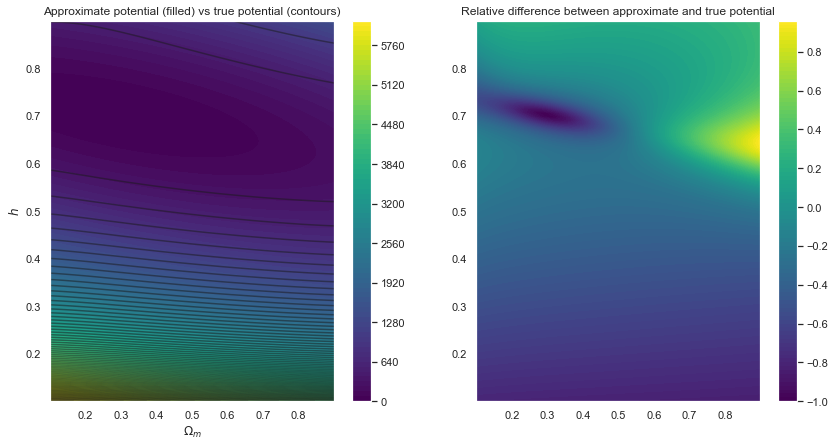

In [108]:
OO = jnp.linspace(0.1, 0.9, 100)
HH = jnp.linspace(0.1, 0.9, 100)
OO, HH = jnp.meshgrid(OO, HH)
UU = jnp.vectorize(potential)(OO, HH)
UU_approx = jnp.vectorize(approx_U)(OO, HH)

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.contourf(OO, HH, UU_approx, 100, cmap="viridis")
plt.colorbar()
plt.contour(OO, HH, UU, 100, colors="k", alpha=0.5)
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$h$")
plt.title("Approximate potential (filled) vs true potential (contours)")
plt.subplot(1, 2, 2)
diff = (UU_approx - UU) / jnp.maximum(jnp.abs(UU),1e-15)
plt.contourf(OO, HH, diff, 100, cmap="viridis")
plt.colorbar()
plt.title("Relative difference between approximate and true potential")
plt.show()


A vrai dire, ce qui compte est surtout que ses dérivées soient approximées correctement (en effet on échantillonnera toujours selon la vraie vraisemblance *a priori*, eg avec le vrai Hamiltonien).

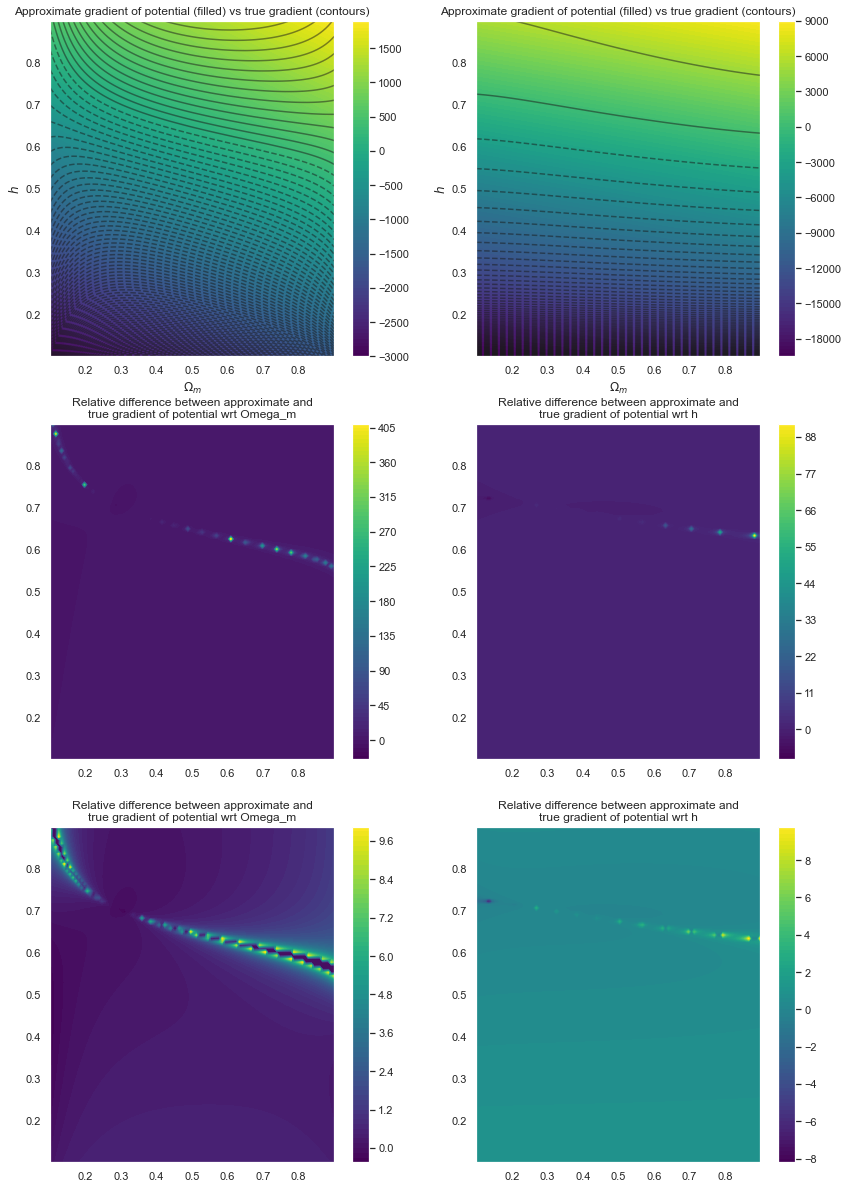

In [106]:
dO = jnp.vectorize(dUdOm)(OO, HH)
dO_approx = jnp.vectorize(approx_dUdOm)(OO, HH)
dh = jnp.vectorize(dUdh)(OO, HH)
dh_approx = jnp.vectorize(approx_dUdh)(OO, HH)

plt.figure(figsize=(14, 21))
plt.subplot(3, 2, 1)
plt.contourf(OO, HH, dO_approx, 100, cmap="viridis")
plt.colorbar()
plt.contour(OO, HH, dO, 100, colors="k", alpha=0.5)
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$h$")
plt.title("Approximate gradient of potential (filled) vs true gradient (contours)")
plt.subplot(3, 2, 2)
plt.contourf(OO, HH, dh_approx, 100, cmap="viridis")
plt.colorbar()
plt.contour(OO, HH, dh, 100, colors="k", alpha=0.5)
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$h$")
plt.title("Approximate gradient of potential (filled) vs true gradient (contours)")
plt.subplot(3, 2, 3)
diff1 = (dO_approx - dO) / jnp.maximum(jnp.abs(dO),1e-15)
plt.contourf(OO, HH, diff1, 100, cmap="viridis")
plt.colorbar()
plt.title("Relative difference between approximate and\ntrue gradient of potential wrt Omega_m")
plt.subplot(3, 2, 4)
diff2 = (dh_approx - dh) / jnp.maximum(jnp.abs(dh),1e-15)
plt.contourf(OO, HH, diff2, 100, cmap="viridis")
plt.colorbar()
plt.title("Relative difference between approximate and\ntrue gradient of potential wrt h")
plt.subplot(3, 2, 5)
diff_indicator = jnp.abs(diff1) < 10
diff_new = jnp.where(diff_indicator, diff1, 0)
plt.contourf(OO, HH, diff_new, 100, cmap="viridis")
plt.colorbar()
plt.title("Relative difference between approximate and\ntrue gradient of potential wrt Omega_m")
plt.subplot(3, 2, 6)
diff_indicator = jnp.abs(diff2) < 10
diff_new = jnp.where(diff_indicator, diff2, 0)
plt.contourf(OO, HH, diff_new, 100, cmap="viridis")
plt.colorbar()
plt.title("Relative difference between approximate and\ntrue gradient of potential wrt h")
plt.show()

## Iteration:  999  ##
Acceptance rate without burn-in: 67.53%
Acceptance rate with burn-in (eg after burning): 67.70%


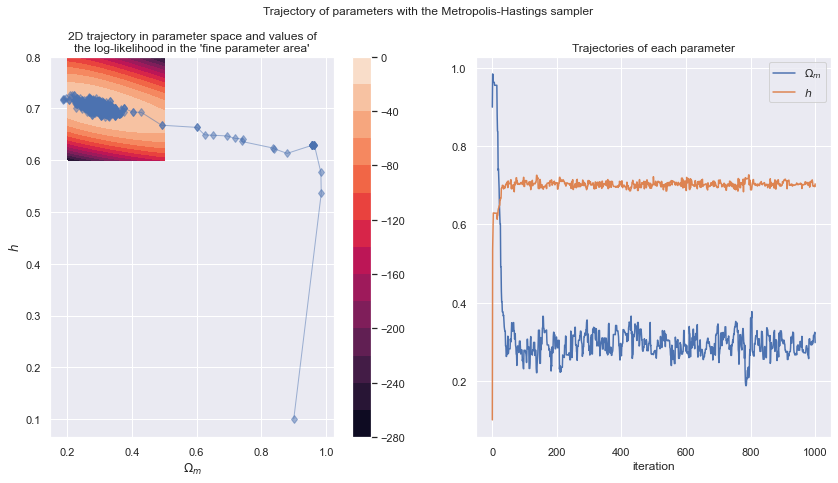

In [109]:
np.random.seed(0)
M = jnp.array([[10, 0.0], [0.0, 1]])
Omegas, hs = HMC_sampler(approx_dUdh, approx_dUdOm, .9, .1, H=Hamiltonian, M=M, nsteps=10, timestep=.02, niter=1000, randomized_N=True)
print("Acceptance rate without burn-in: %.2f%%" % (100*compute_acceptance_rate(Omegas, hs)))
print("Acceptance rate with burn-in (eg after burning): %.2f%%" % (100*compute_acceptance_rate(Omegas, hs, start=100)))

plot_contour_and_trajectory(logL, Omegas, hs)

Le coût (en temps) est considérablement plus bas.

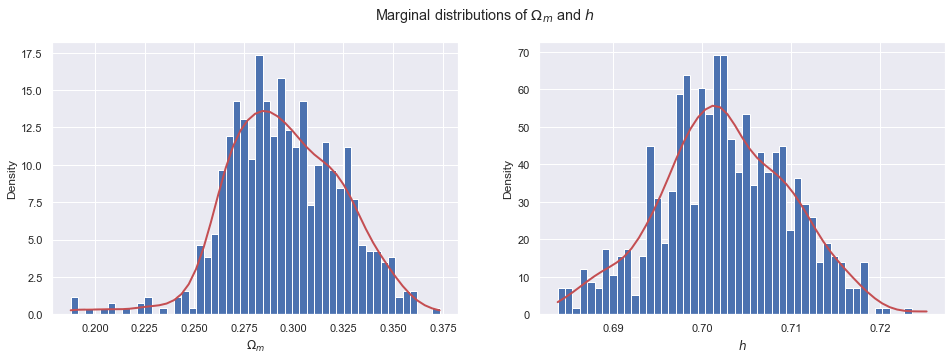

In [168]:
chain_sec7 = np.array([Omegas, hs]).T
plot_marginals(chain_sec7, burn_in=300, title=r"Marginal distributions of $\Omega_m$ and $h$")

## Iteration:  999  ##
Acceptance rate without burn-in: 68.73%
Acceptance rate with burn-in (eg after burning): 68.04%


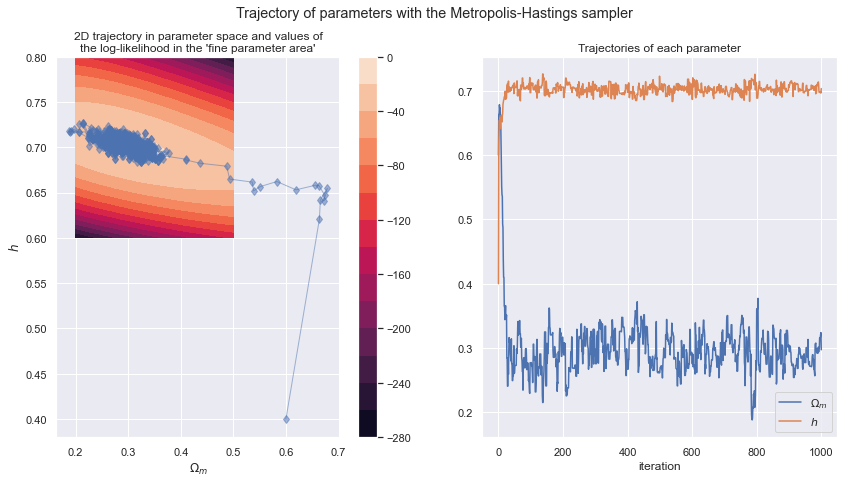

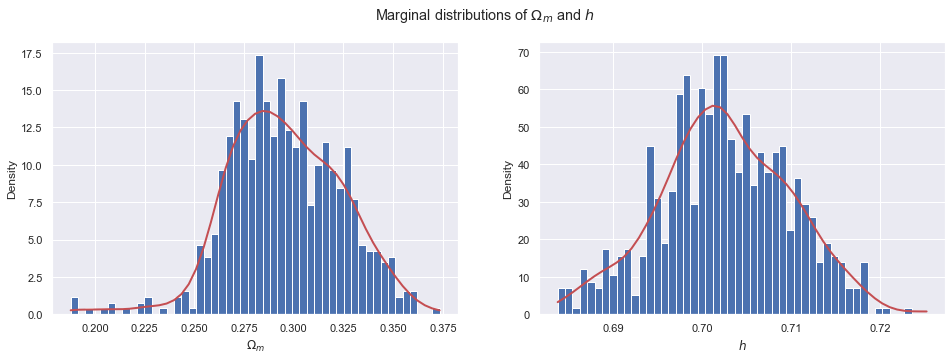

In [169]:
np.random.seed(0)
M = jnp.array([[10, 0.0], [0.0, 1]])
Omegas, hs = HMC_sampler(approx_dUdh, approx_dUdOm, .6, .4, H=Hamiltonian, M=M, nsteps=10, timestep=.02, niter=1000, randomized_N=True)
print("Acceptance rate without burn-in: %.2f%%" % (100*compute_acceptance_rate(Omegas, hs)))
print("Acceptance rate with burn-in (eg after burning): %.2f%%" % (100*compute_acceptance_rate(Omegas, hs, start=100)))

plot_contour_and_trajectory(logL, Omegas, hs)
chain_sec7 = np.array([Omegas, hs]).T
plot_marginals(chain_sec7, burn_in=300, title=r"Marginal distributions of $\Omega_m$ and $h$")

## Iteration:  999  ##
Acceptance rate without burn-in: 51.65%
Acceptance rate with burn-in (eg after burning): 52.16%


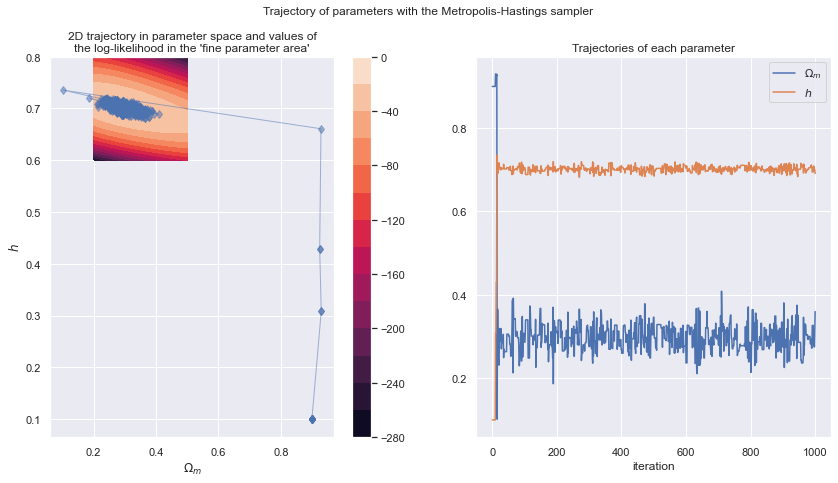

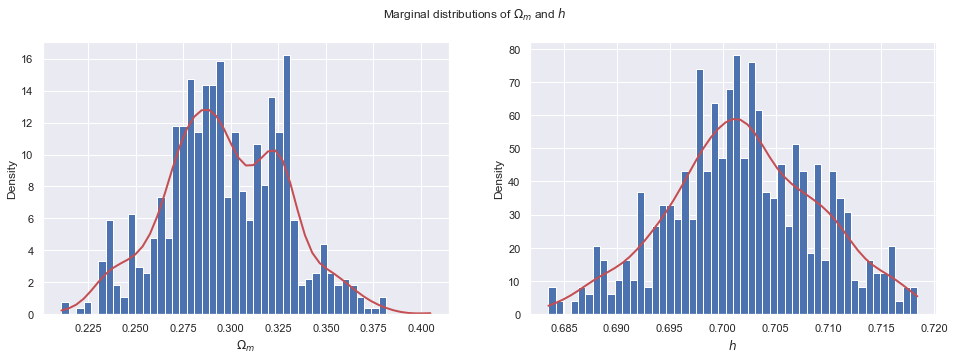

In [110]:
np.random.seed(0)
M = jnp.array([[10, 0.0], [0.0, 1]])
Omegas, hs = HMC_sampler(approx_dUdh, approx_dUdOm, .9, .1, H=Hamiltonian, M=M, nsteps=20, timestep=.1, niter=1000, randomized_N=True)
print("Acceptance rate without burn-in: %.2f%%" % (100*compute_acceptance_rate(Omegas, hs)))
print("Acceptance rate with burn-in (eg after burning): %.2f%%" % (100*compute_acceptance_rate(Omegas, hs, start=100)))

plot_contour_and_trajectory(logL, Omegas, hs)
chain_sec7 = np.array([Omegas, hs]).T
plot_marginals(chain_sec7, burn_in=300, title=r"Marginal distributions of $\Omega_m$ and $h$")

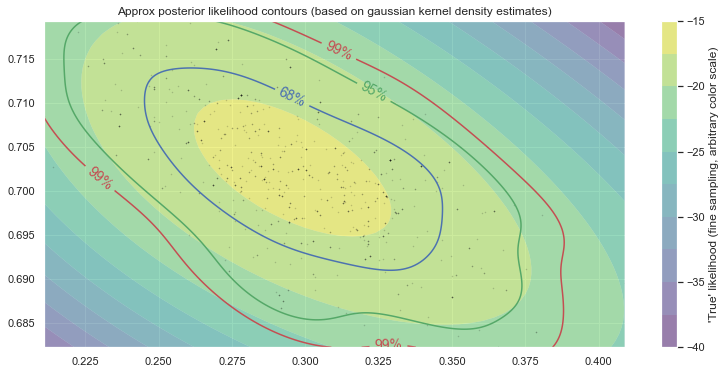

mean(h)= 0.702, mean(Omega_m) = 0.297


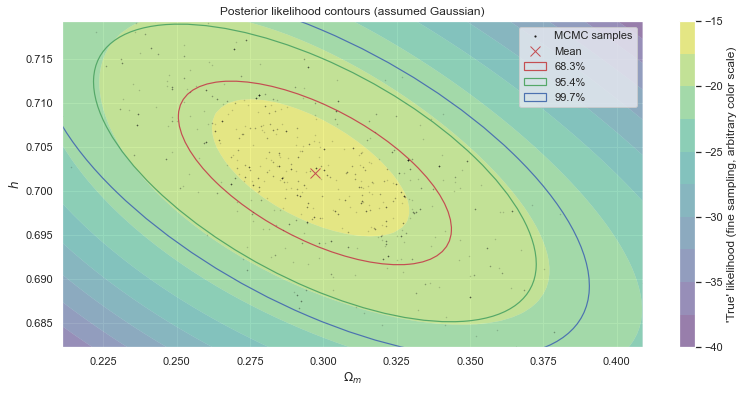

In [117]:
superimpose_posteriors_contours_on_true_likelihood(logL, chain_sec7, burn_in=200, bw=.5, assumed_Gaussian=False)
mean_sec7, covariance_sec7 = estimate_mean_and_covariance_of_parameters(chain_sec7, burn_in=200)
print("mean(h)= %.3f, mean(Omega_m) = %.3f" % (mean_sec7[1], mean_sec7[0]))
superimpose_posteriors_contours_on_true_likelihood(logL, chain_sec7, burn_in=200, title="(Gaussian) posterior likelihood contours")

### Correlation length

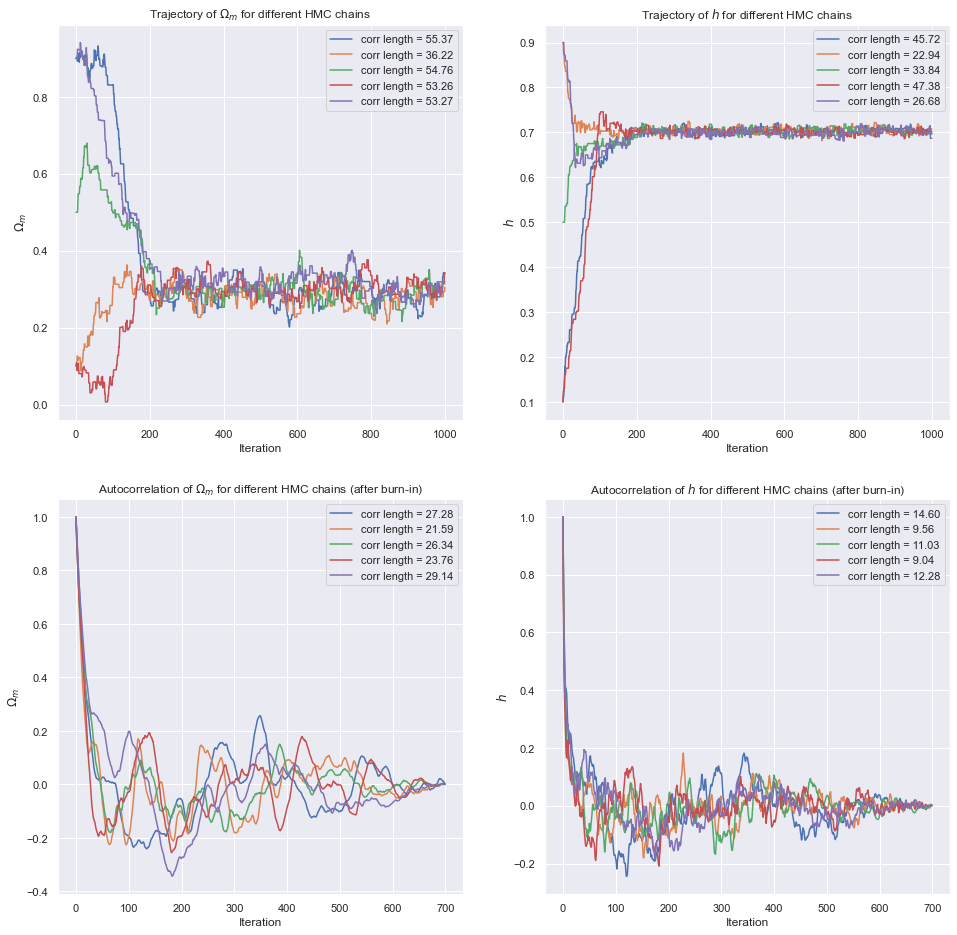

In [177]:
burn_length = 300

plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
for i in range(5):
    time = compute_autocorr_time(Omegas_list_top_hat[i])
    plt.plot(Omegas_list_top_hat[i], label="corr length = %.2f" % time)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel(r"$\Omega_m$")
plt.title("Trajectory of $\Omega_m$ for different HMC chains")

plt.subplot(2, 2, 2)
for i in range(5):
    time = compute_autocorr_time(hs_list_top_hat[i])
    plt.plot(hs_list_top_hat[i], label="corr length = %.2f" % time)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel(r"$h$")
plt.title("Trajectory of $h$ for different HMC chains")

plt.subplot(2, 2, 3)
for i in range(5):
    time = compute_autocorr_time(Omegas_list_top_hat[i], start=burn_length)
    plt.plot(autocorr(Omegas_list_top_hat[i], start=burn_length), label="corr length = %.2f" % time)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel(r"$\Omega_m$")
plt.title("Autocorrelation of $\Omega_m$ for different HMC chains (after burn-in)")

plt.subplot(2, 2, 4)
for i in range(5):
    time = compute_autocorr_time(hs_list_top_hat[i], start=burn_length)
    plt.plot(autocorr(hs_list_top_hat[i], start=burn_length), label="corr length = %.2f" % time)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel(r"$h$")
plt.title("Autocorrelation of $h$ for different HMC chains (after burn-in)")
plt.show()



## Three parameters problem

Dans le modèle standard, et pour un Univers plat ($\Omega_k$=0), la distance de luminosité (ajustée à $h=1$) est donnée par
$$
D^*_{L} = \frac{c}{100}\,(1+z) \int_0^z \frac{dz'}{\sqrt{1 - \Omega_{m} + \Omega_{m} (1+z')^3}}
$$

Pour un Univers avec une courbure $\Omega_k>0$, la distance de luminosité est donnée, dans le modèle standard, par
$$
D^*_{L} = \dfrac{(1+z)\,c}{100\sqrt{|\Omega_k|}}\,S(\Omega_k;z)
$$
où
$$
S(\Omega_k;z) = \left\{
    \begin{array}{ll}
        \sinh\left(r(z)\right) & \text{si } \Omega_k>0\\
        \sin\left(r(z)\right) & \text{si } \Omega_k<0\\
        r(z) & \text{si } \Omega_k=0
    \end{array}
\right.
$$
et
$$
r(z) = \sqrt{|\Omega_k|}\,\int_0^z \dfrac{dz'}{\sqrt{ \Omega_\Lambda + \Omega_k (1+z')^2 + \Omega_{m} (1+z')^3}}
$$

On commence par écrire une routine pour évaluer l'intégrale $r$.

In [118]:
def integrate_r_with_Simpson_formula(f, zmax, n):
    zz = np.linspace(zmax/n, zmax, n)
    h = zz[1] - zz[0]
    sum = 0
    for i in range(1, n - 1):
        if i % 2 == 0:
            sum += 2 * f(zz[i])
        else:
            sum += 4 * f(zz[i])
    return (h / 3) * (f(zz[0]) + f(zz[-1]) + sum)

def integrande(Ol,Ok,Om,t):
    return 1 / np.sqrt(np.maximum(Ol + Ok * (1 + t) ** 2 + Om * (1 + t) ** 3, 1e-8))


def r(Ol,Om,z,n=100):
    Ok = Om + Ol - 1
    return integrate_r_with_Simpson_formula(lambda t: integrande(Ol,Ok,Om,t), z, n)

def S(Ol,Om,z,n=100,kind=None):
    Ok = Om + Ol - 1
    if kind is None:
        if Ok > 0:
            return np.sinh(np.sqrt(np.abs(Ok))*r(Ol,Om,z,n)) / np.sqrt(np.abs(Ok))
        elif Ok < 0:
            return np.sin(np.sqrt(np.abs(Ok))*r(Ol,Om,z,n)) / np.sqrt(np.abs(Ok))
        else:
            return r(Ol,Om,z,n)
    else:
        if kind == "sinh":
            return np.sinh(np.sqrt(np.abs(Ok))*r(Ol,Om,z,n)) / np.sqrt(np.abs(Ok))
        elif kind == "sin":
            return np.sin(np.sqrt(np.abs(Ok))*r(Ol,Om,z,n)) / np.sqrt(np.abs(Ok))
        elif kind == "r":
            return r(Ol,Om,z,n)
        else:
            raise ValueError("kind must be 'sinh', 'sin' or 'r'")

def DL_star_Simpson(Ol,Om,z,n=1000,c=CONST_c,kind=None):
    return c * (1 + z) * S(Ol,Om,z,n,kind) / 100

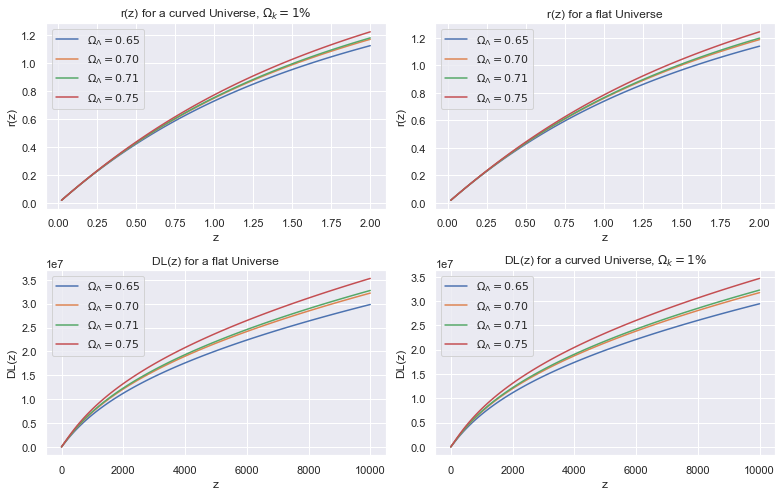

In [119]:
zz = np.linspace(2/100, 2, 100)
zz_large = np.linspace(2/100, 10000, 100)
plt.figure(figsize=(11, 7))
plt.subplot(2, 2, 1)
range_ol = [0.65, 0.7, 0.71, 0.75]
for ol in range_ol:
    om = 1.01-ol
    plt.plot(zz, r(ol, om, zz), label=r"$\Omega_\Lambda = %.2f$" % ol)
plt.xlabel("z")
plt.ylabel("r(z)")
plt.title("r(z) for a curved Universe, $\Omega_k=1\%$")
plt.legend()
plt.subplot(2, 2, 2)
for ol in range_ol:
    om = 1.0-ol
    plt.plot(zz, r(ol, om, zz), label=r"$\Omega_\Lambda = %.2f$" % ol)
plt.xlabel("z")
plt.ylabel("r(z)")
plt.title("r(z) for a flat Universe")
plt.legend()
plt.subplot(2, 2, 3)
for ol in range_ol:
    om = 1.0-ol
    plt.plot(zz_large, DL_star_Simpson(ol, om, zz_large), label=r"$\Omega_\Lambda = %.2f$" % ol)
plt.xlabel("z")
plt.ylabel("DL(z)")
plt.title("DL(z) for a flat Universe")
plt.legend()
plt.subplot(2, 2, 4)
for ol in range_ol:
    om = 1.01-ol
    plt.plot(zz_large, DL_star_Simpson(ol, om, zz_large), label=r"$\Omega_\Lambda = %.2f$" % ol)
plt.xlabel("z")
plt.ylabel("DL(z)")
plt.title("DL(z) for a curved Universe, $\Omega_k=1\%$")
plt.legend()
plt.tight_layout()
plt.show()

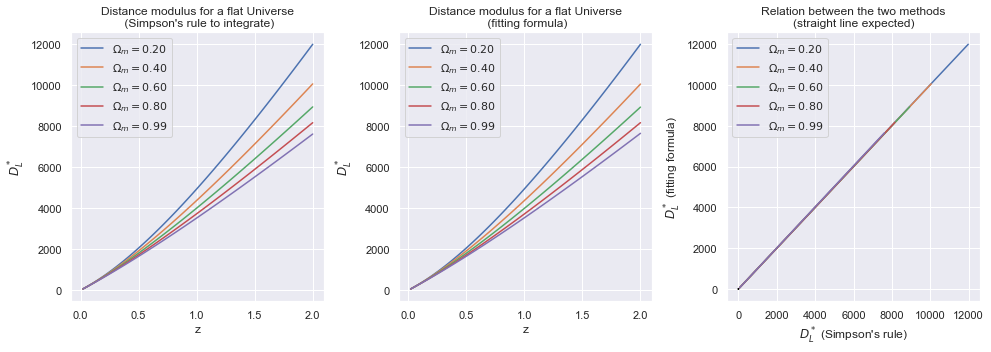

In [120]:
OOm = [0.2, 0.4, 0.6, 0.8, 0.99]
Ok = 0

plt.figure(figsize=(14, 5))
for Om in OOm:
    Ol = Ok - Om + 1
    plt.subplot(1, 3, 1)
    Simpson = DL_star_Simpson(Ol, Om, zz)
    plt.plot(zz, Simpson, label=r"$\Omega_m = %.2f$" % Om)
    plt.xlabel("z")
    plt.ylabel(r"$D_L^*$")
    plt.legend()
    plt.title("Distance modulus for a flat Universe\n (Simpson's rule to integrate)")
    plt.subplot(1, 3, 2)
    fit = DL_star(zz, Om)
    plt.plot(zz, fit, label=r"$\Omega_m = %.2f$" % Om)
    plt.xlabel("z")
    plt.title("Distance modulus for a flat Universe\n (fitting formula)")
    plt.ylabel(r"$D_L^*$")
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(Simpson, fit, label=r"$\Omega_m = %.2f$" % Om)
    plt.plot(zz, zz, color="black")
    plt.xlabel(r"$D_L^*$ (Simpson's rule)")
    plt.ylabel(r"$D_L^*$ (fitting formula)")
    plt.title("Relation between the two methods\n(straight line expected)")
    plt.legend()
plt.tight_layout()
plt.show()

### Write an emulator of the data model

In [121]:
zz_in_data = np.array(jla_mub.z)
nz = len(zz_in_data)
nx = 200 # takes ~20 secondes with nx=500 and n=1000, to loop on all z
ny = nx
extent = [1/nx, 1, 1/ny, 1]
OL = np.linspace(extent[0], extent[1], nx)
OO = np.linspace(extent[2], extent[3], ny)

OOL, OOm = np.meshgrid(OL, OO)
OOL_flat = OOL.ravel()
OOm_flat = OOm.ravel()
OK = OOm_flat + OOL_flat - 1

kind_sinh = np.where(OK > 0)
kind_r = np.where(OK == 0)
kind_sin = np.where(OK < 0)

DL_star_Simpson_grid_interp_full = np.zeros((nz,nx,ny))
for i in range(nz):
    z = zz_in_data[i]
    DL_star_Simpson_grid_interp = np.zeros((nx*ny))
    DL_star_Simpson_grid_interp[kind_sinh] = DL_star_Simpson(OOL_flat[kind_sinh], OOm_flat[kind_sinh], z, kind="sinh")
    DL_star_Simpson_grid_interp[kind_r] = DL_star_Simpson(OOL_flat[kind_r], OOm_flat[kind_r], z, kind="r")
    DL_star_Simpson_grid_interp[kind_sin] = DL_star_Simpson(OOL_flat[kind_sin], OOm_flat[kind_sin], z, kind="sin")
    DL_star_Simpson_grid_interp = DL_star_Simpson_grid_interp.reshape((nx, ny))
    DL_star_Simpson_grid_interp_full[i] = DL_star_Simpson_grid_interp

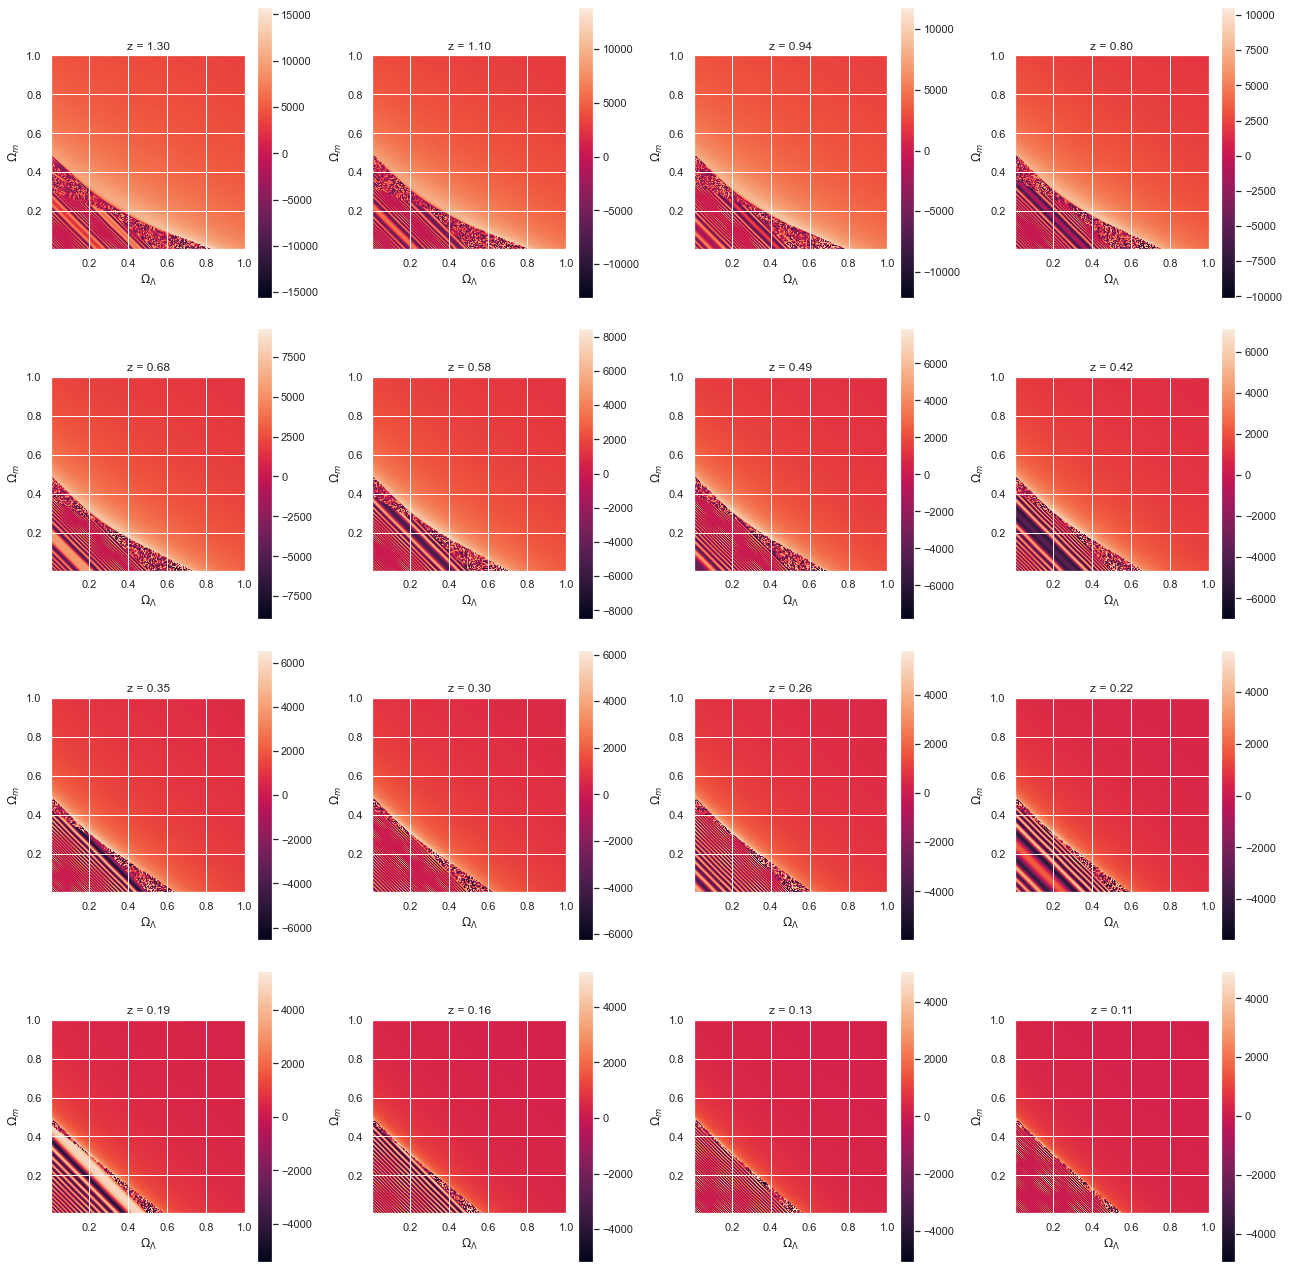

In [122]:
plt.figure(figsize=(18, 18))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(DL_star_Simpson_grid_interp_full[-(i+1)], extent=extent, origin="lower")
    plt.xlabel(r"$\Omega_\Lambda$")
    plt.ylabel(r"$\Omega_m$")
    plt.title("z = %.2f" % zz_in_data[-(i+1)])
    plt.colorbar()
plt.tight_layout()
plt.show()

In [123]:
z_to_id_dict = {z: i for i, z in enumerate(zz_in_data)}
def interpolate(z_id, OL, Om, id=True):
    if not id:
        z_id = z_to_id_dict[z]
    nx = DL_star_Simpson_grid_interp_full.shape[1]
    ny = DL_star_Simpson_grid_interp_full.shape[2]
    # we perform bilinear interpolation:
    x = (OL - extent[0])/(extent[1] - extent[0])*(nx-1)
    y = (Om - extent[2])/(extent[3] - extent[2])*(ny-1)
    x1 = int(x)
    x2 = x1 + 1
    if x2 >= nx-1:
        x1 -= 1
        x2 -= 1
        if x2 >= nx-1:
            x1 -= 1
            x2 -= 1
    y1 = int(y)
    y2 = y1 + 1
    if y2 >= ny-1:
        y1 -= 1
        y2 -= 1
        if y2 >= ny-1:
            y1 -= 1
            y2 -= 1
    f11 = DL_star_Simpson_grid_interp_full[z_id, x1, y1]
    f12 = DL_star_Simpson_grid_interp_full[z_id, x1, y2]
    f21 = DL_star_Simpson_grid_interp_full[z_id, x2, y1]
    f22 = DL_star_Simpson_grid_interp_full[z_id, x2, y2]

    return (f11*(x2-x)*(y2-y) + f21*(x-x1)*(y2-y) + f12*(x2-x)*(y-y1) + f22*(x-x1)*(y-y1))/((x2-x1)*(y2-y1))

In [137]:
def mu_interpolator(z, Om, OL, h, c=CONST_c):
    return 25 - 5*np.log10(h) + 5*np.log10(interpolate(z, OL, Om))

def mu_interpolator_z_index(Om, OL, h, c=CONST_c):
    return 25 - 5*np.log10(h) + 5*np.log10(interpolate(range(len(jla_mub.z)), OL, Om))

def logL_3d(Om, OL, h, c=CONST_c):
    if Om < 0 or Om > 1 or OL < 0 or OL > 1 or h < 0 or h > 1:
        return -np.inf
    mus_th = mu_interpolator_z_index(Om, OL, h)
    return -0.5 * np.dot(np.dot((jla_mub.mu - mus_th), SIGMA_INV), (jla_mub.mu - mus_th))

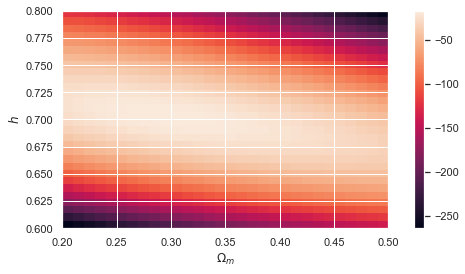

In [138]:
OO = np.linspace(.2, .5, 30)
hh = np.linspace(.6, .8, 30)
OO_hh = np.meshgrid(OO, hh)
OO_hh = np.array(OO_hh).reshape(2, -1).T
likelihoods = [logL(O, h) for O, h in OO_hh]
likelihoods = np.array(likelihoods).reshape(30, 30)

plt.figure(figsize=(9, 4))
plt.imshow(likelihoods, extent=[.2, .5, .6, .8], origin="lower")
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$h$")
plt.colorbar()
plt.show()

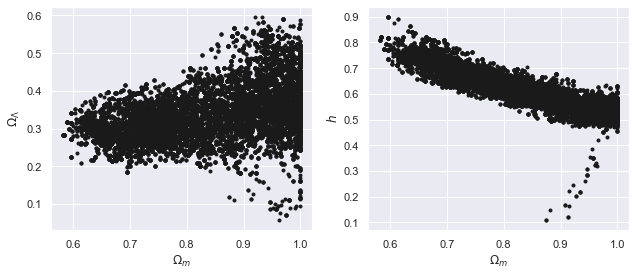

In [176]:
samples = MH_3d_sampler_gaussian(logL_3d, 0.9, 0.1, 0.1, niter=20000, sigma=.02)

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.plot(samples[:, 0], samples[:, 1], "k.")
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$\Omega_\Lambda$")
plt.subplot(1, 2, 2)
plt.plot(samples[:, 0], samples[:, 2], "k.")
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$h$")
plt.tight_layout()
plt.show()


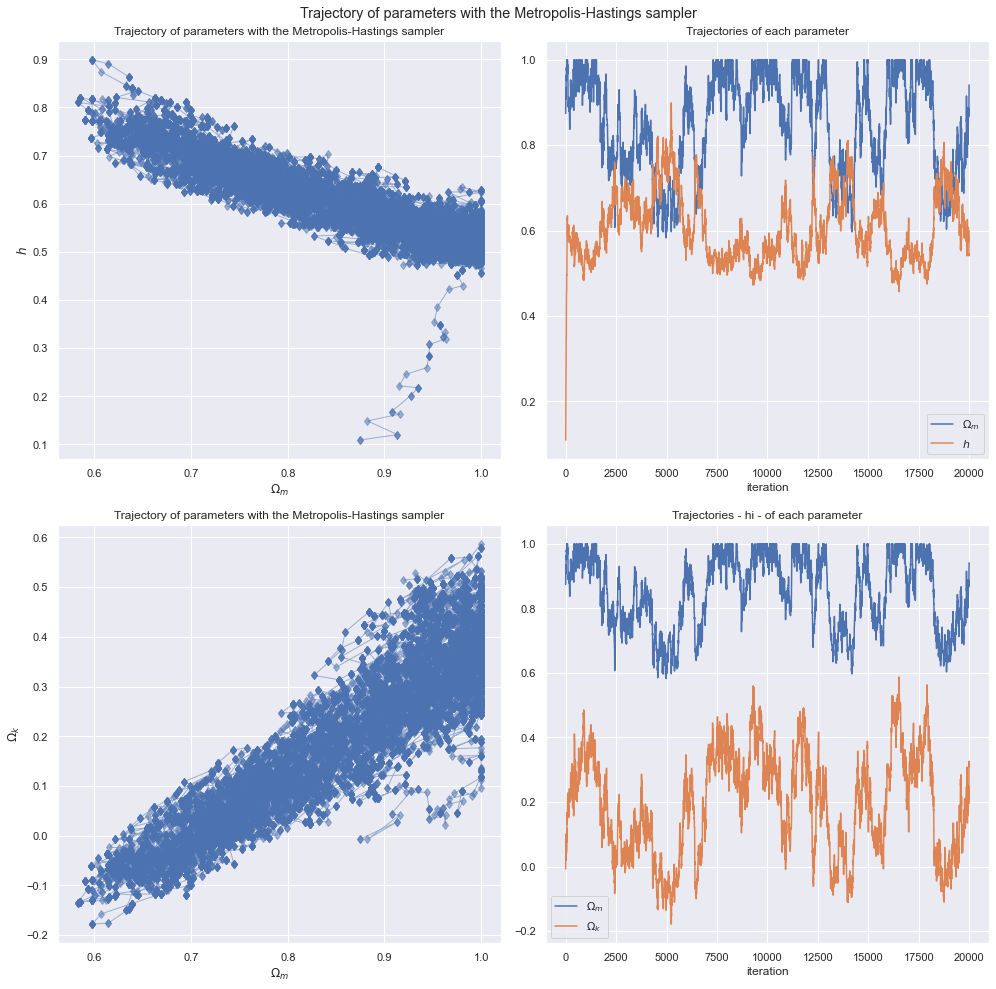

In [179]:
plot_contour_and_trajectory_3dL(samples, burn_length=0, overwrite=False, label=None, title="Trajectory of parameters with the Metropolis-Hastings sampler")

Triangle plots with `corner`, with last 90% of the points (note that I did not compute credible regions by hand).

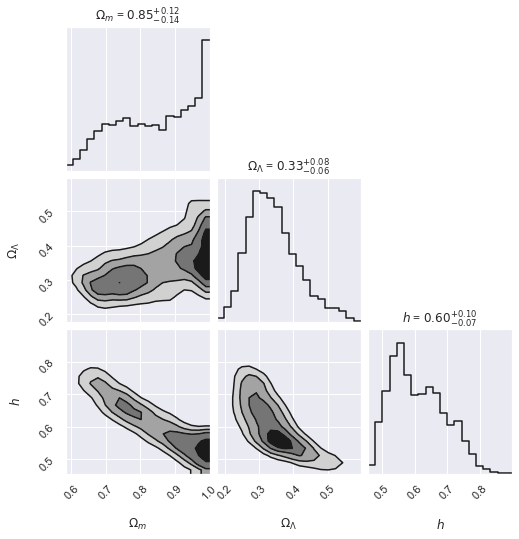

In [193]:
# triangle plots:
import corner
corner.corner(samples[2000:], labels=[r"$\Omega_m$", r"$\Omega_\Lambda$", r"$h$"], show_titles=True, title_kwargs={"fontsize": 12}, bins=20, smooth=1, smooth1d=.5, plot_contours=True, plot_datapoints=False, fill_contours=True)
plt.show()

## Retour sur l'expression des distances de luminosité

### Rappels de cosmo

Pour un UHI, la métrique FLRW (Friedmann-Lemaître-Robertson-Walker) est donnée par
$$
ds^2 = c^2\,dt^2 - a^2(t)\left[ \dfrac{dr^2}{1-kr^2} + r^2d\Omega^2 \right]
$$

Les équations d'Einstein $G^{\mu\nu} + \Lambda g^{\mu\nu} = 8\pi G\,T^{\mu\nu}$ deviennent alors les équations de Friedmann-Lemaître :
$$
\begin{align}
\dfrac{1}{a^2}\dfrac{d^2a}{dt^2} &= -\dfrac{4\pi G}{3}\,\rho(t)\\
\dfrac{1}{a^2}\dfrac{da}{dt} &= -\dfrac{4\pi G}{3}\,\left(\rho(t) + 3p(t)\right)
\end{align}
$$

Elles nous permettent notamment d'estimer très facilement (à l'ordre 1) les grandes ères de l'Histoire l'Univers.

C'est la première équation de Friedmann qui nous intéresse. Elle donne le taux d'expansion en fonction des densités $\rho$, de la courbure $k$, et de la constante cosmologique $\Lambda$.

Ecrite en fonction des paramètres de densité adimensionnés $\Omega_i = \rho_i/\rho_{\textrm{crit}}$, on obtient :
$$
H(a) = H_0\,\sqrt{\Omega_{m} a^{-3} + \Omega_{\Lambda} + \Omega_k a^{-2}}
$$
en supposant que $w_{\textrm{DE}} = -1$, et que la masse des neutrinos est négligeable.

### Les notions de distance dont on a besoin

Distance propre : c'est la distance entre deux objets à temps cosmologique fixé.

Distance comobile : c'est la distance fondamentale "intrinsèque" entre deux observateurs, qui ne varie pas avec l'expanison de l'Univers. Pour un observateur qui ne se déplace pas par rapport à la source lumineuse, la distance comobile est donnée au premier ordre (ie si elle n'est pas trop grande) par $d_{\textrm{propre}} = a(z_\textrm{cste}) d_{\textrm{comobile}}$. Plus généralement, le paramètre de Hubble évoluant dans le temps, on peut écrire la distance comobile comme l'intégrale des distances propres infinitésimales le long de l'évolution de l'Univers :

$$
D_{c}(z) = c\,\int_0^z \dfrac{dz'}{H(z')} = c\,\int_0^z \dfrac{dz'}{\sqrt{\Omega_{m} a^{-3} + \Omega_{\Lambda} + \Omega_k a^{-2}}}
$$

### Lien entre la luminosité d'une supernova et sa distance

Soit $L$ la quantité de lumière totale émise par une source lumineuse, en l'occurence une supernova. A la distance $d$, elle se répartit sur une sphère de surface $4\pi d^2$. La luminosité "reçue" (ie la densité de flux de la luminosité en le pt d'observation, qu'on appelle souvent tt simplement "flux") $L'$ est donc donnée par $L' = L/(4\pi d^2)$.

Si on observe la densité de flux $L'$, la distance $d$ qui apparait dans la relation, inconnue, est appelée distance de luminosité. C'est toujours cette quantité qui est appelée distance de luminosité, mais il faut comprendre qu'à temps cosmologique fixé, elle ne correspondrait à la distance propre que dans un Univers euclidien.

Dans le modèle standard, la distance de luminositée est liée à la distance comobile évoquée ci-dessus, mais également à la distance auglaire liée au fait que le diamètre apparent d'une source lumineuse est donné par $d_{\textrm{apparent}} = d_{\textrm{comobile}}\,D_A(z)$, où $D_A(z)$ est la distance auglaire.

$$
D_L= (1+z) D_c = (1+z)^2 D_A
$$

Pour une courbure nulle, on obient ainsi la relation donnée au début du calepin :
$$
D_L(z) = \dfrac{(1+z)c}{H_0}\,\int_0^z \dfrac{dz'}{\sqrt{\Omega_{m} a^{-3} + \Omega_{\Lambda}}}
$$